
## BLOOD CELL TYPE PREDICTION


## 1. Environment preparation: Installing the Dependencies and Uploading the Dataset

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers, Input, optimizers, losses, callbacks
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import psutil

In [2]:
# Setting seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()


In [3]:
from medmnist import BloodMNIST, INFO

def load_bloodmnist(img_size):
    info = INFO["bloodmnist"]
    num_classes = len(info["label"])

    train_dataset = BloodMNIST(split="train", download=True, size=img_size)
    val_dataset = BloodMNIST(split="val", download=True, size=img_size)
    test_dataset = BloodMNIST(split="test", download=True, size=img_size)

    # Extract the files
    train_images, train_labels = train_dataset.imgs, train_dataset.labels
    val_images, val_labels = val_dataset.imgs, val_dataset.labels
    test_images, test_labels = test_dataset.imgs, test_dataset.labels

    return train_images, train_labels, val_images, val_labels, test_images, test_labels, num_classes

train_images, train_labels, val_images, val_labels, test_images, test_labels, NUM_CLASSES = load_bloodmnist(img_size=64)

## 2. Exploratory Data Analysis

Before training the model, the exploratory data analysis is needed to better understand the dataset and ensure it's suitability for modeling.


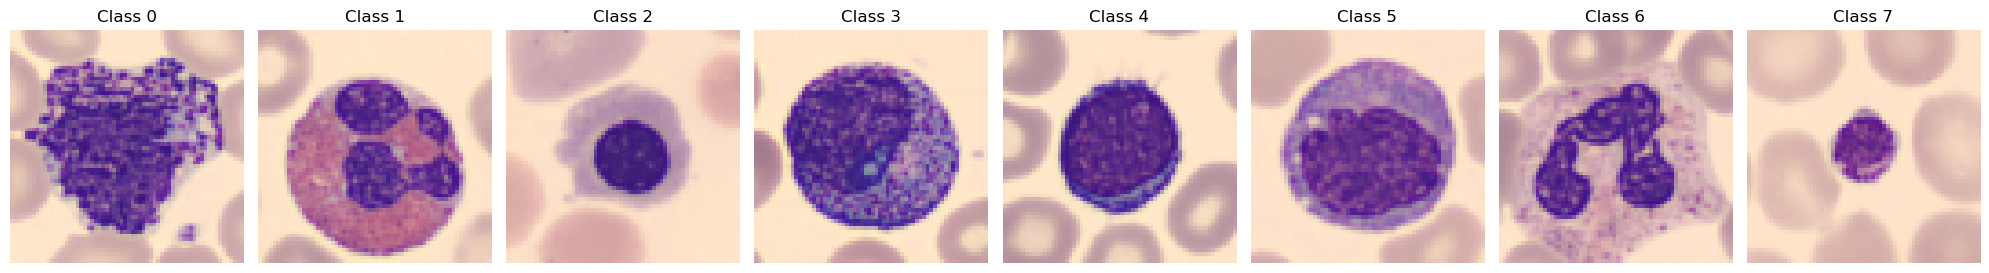

In [4]:
# Get the unique classes
classes = np.unique(train_labels)

# Prepare figure
fig, axes = plt.subplots(1, len(classes), figsize=(20, 5))

for i, cls in enumerate(classes):
    # Get indices of all images for this class
    indices = np.where(train_labels == cls)[0]
    
    # Randomly pick one index
    random_index = random.choice(indices)
    img = train_images[random_index]

    # Show the image
    axes[i].imshow(img.astype(np.uint8))
    axes[i].set_title(f"Class {cls}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [5]:
# Checking that each class is present in each dataset
num_classes_train = len(np.unique(train_labels))
num_classes_val = len(np.unique(val_labels))
num_classes_test = len(np.unique(test_labels))
print(f'Number of classes in train set: {num_classes_train}')
print(f'Number of classes in val set: {num_classes_val}')
print(f'Number of classes in test set: {num_classes_test}')

Number of classes in train set: 8
Number of classes in val set: 8
Number of classes in test set: 8


To assess potential class imbalance, the number of samples per class was calculated for the training, validation, and test sets.

A helper functions `class_distribution()` and `plot_class_distribution()` are designed to compute sample counts per class and then visualize the results.


In [6]:
# Exploring class distribution
def class_distribution(labels):
    flat_labels = labels.flatten()
    label_counts = {label: np.sum(flat_labels == label) for label in np.unique(flat_labels)}
    return label_counts


train_counts = class_distribution(train_labels)
val_counts = class_distribution(val_labels)
test_counts = class_distribution(test_labels)

# Print class distributions
print("Train class distribution:", train_counts)
print("Validation class distribution:", val_counts)
print("Test class distribution:", test_counts)

Train class distribution: {0: 852, 1: 2181, 2: 1085, 3: 2026, 4: 849, 5: 993, 6: 2330, 7: 1643}
Validation class distribution: {0: 122, 1: 312, 2: 155, 3: 290, 4: 122, 5: 143, 6: 333, 7: 235}
Test class distribution: {0: 244, 1: 624, 2: 311, 3: 579, 4: 243, 5: 284, 6: 666, 7: 470}


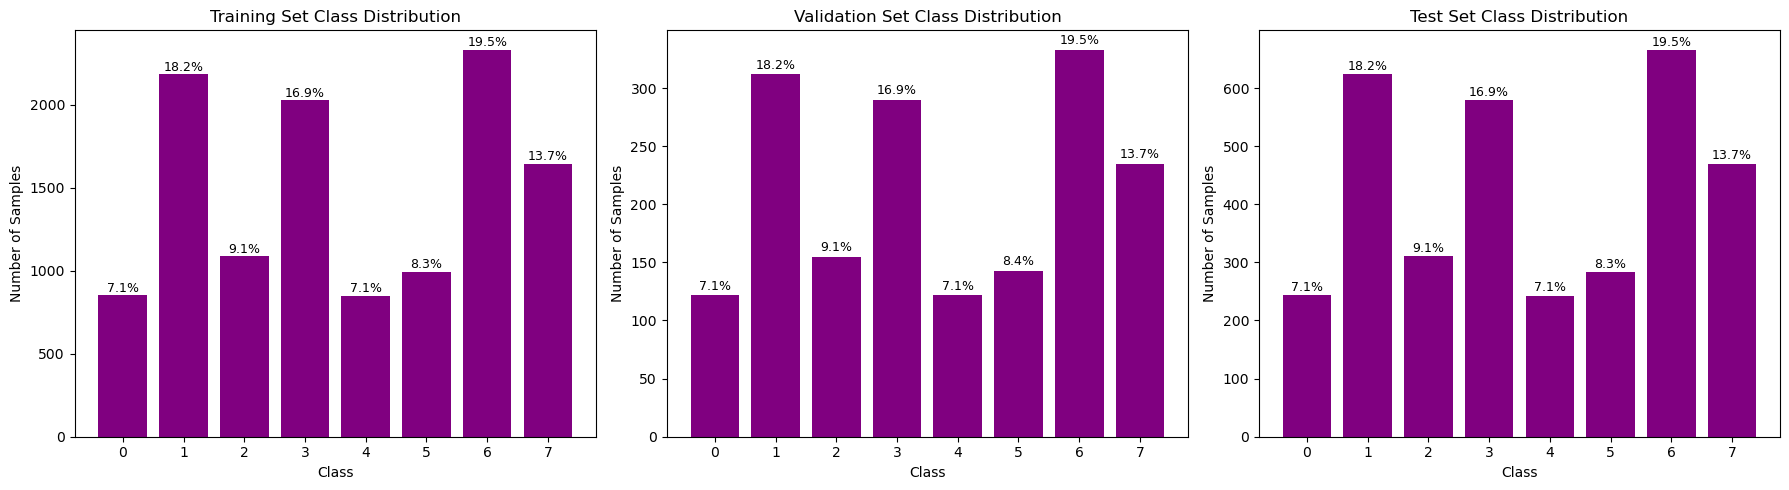

In [7]:
def plot_class_distribution(ax, counts, title):
    total = sum(counts.values())
    bars = ax.bar(counts.keys(), counts.values(), color='purple')
    ax.set_xlabel("Class")
    ax.set_ylabel("Number of Samples")
    ax.set_title(title)
    ax.set_xticks(list(counts.keys()))

    for bar in bars:
        height = bar.get_height()
        percentage = (height / total) * 100
        ax.text(bar.get_x() + bar.get_width() / 2, height + 2,
                f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Call the function for each subplot
plot_class_distribution(axes[0], train_counts, "Training Set Class Distribution")
plot_class_distribution(axes[1], val_counts, "Validation Set Class Distribution")
plot_class_distribution(axes[2], test_counts, "Test Set Class Distribution")

plt.tight_layout()
plt.show()


## 3. Dataset preparation

From EDA it can be seen that class dictrubution is highly unbalanced, hence the Train Set needs to be augmented in order to balance the class distribution and ensure the good performance of the model on the minority classes. 

The two functions were developed:
- `create_train_set()` is designed for the Train Set creation. It **normalizes the images, augments the under-represented classes** and **one-hot-encodes the labels**.
- `create_test_set()` is designed for the Validation and Test set creation. It **normalizes the images** and **one-hot-encodes the labels**, but **it does not balance the datasets** in order to preserve the original data distribution. This ensures that model evaluation reflects real-world performance on naturally occurring, unaltered examples.

### Data Augmentation Strategy

To enhance the model's robustness and generalization ability, a simple data augmentation strategy was employed. Given that the dataset consists of microscopic images of blood cells, their orientation in captured images can vary significantly. Blood cells can naturally appear in different rotated or flipped positions under the microscope.

Therefore, the following augmentations were applied:

- **Horizontal Flip:** Randomly flips images horizontally.
- **Vertical Flip:** Randomly flips images vertically.

These transformations are particularly suitable for this type of biomedical imagery, as the semantic meaning of the cells remains unchanged regardless of these flips. This helps the model become more invariant to orientation and improves its performance on unseen data.


In [8]:
def create_train_set(train_images, train_labels, seed=42, visualize=True, samples_per_class=5):
    """
    Normalizes images, applies data augmentation to underrepresented classes, and one-hot encodes labels.

    Args:
        train_images (numpy array): Training images of shape (_num of instances_, 64, 64, 3).
        train_labels (numpy array): Training labels of shape (_num of instances_, 1).
        visualize (bool): Whether to show augmented image samples.
        samples_per_class (int): Number of augmented images to display per class.

    Returns:
        train_images_balanced (numpy array): Augmented & normalized images.
        train_labels_balanced (numpy array): One-hot encoded labels.
    """
    np.random.seed(seed)
    random.seed(seed)

    # Normalize images
    train_images = train_images.astype("float32") / 255.0
    train_labels = train_labels.flatten()

    unique_labels, counts = np.unique(train_labels, return_counts=True)
    class_counts = dict(zip(unique_labels, counts))
    print("Initial Class Distribution:", class_counts)

    max_count = max(class_counts.values())
    print(f"Target maximum count for each class: {max_count}")

    datagen = ImageDataGenerator(
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True) # randomly flip images vertically

    augmented_images = []
    augmented_labels = []

    # For visualization storage
    vis_augmented = {label: [] for label in unique_labels}

    for label in unique_labels:
        cur_class_indices = np.where(train_labels == label)[0]
        cur_class_images = train_images[cur_class_indices]
        current_count = class_counts[label]
        num_to_add = max_count - current_count

        if num_to_add > 0:
            print(f"Augmenting class {label}: Need to add {num_to_add} samples.")
            for _ in range(num_to_add):
                idx_to_augment = np.random.randint(0, len(cur_class_images))
                img_to_augment = cur_class_images[idx_to_augment].reshape((1, 64, 64, 3))
                batch = next(datagen.flow(img_to_augment, batch_size=1))
                augmented_images.append(batch[0])
                augmented_labels.append(label)

                # Collect samples for visualization
                if len(vis_augmented[label]) < samples_per_class:
                    vis_augmented[label].append(batch[0])

    # Visualization block
    if visualize:
        for label in unique_labels:
            aug_samples = vis_augmented[label]
            if aug_samples:
                fig, axes = plt.subplots(1, len(aug_samples), figsize=(12, 3))
                fig.suptitle(f"Augmented samples for class {label}")
                for i, img in enumerate(aug_samples):
                    axes[i].imshow(img)
                    axes[i].axis('off')
                plt.show()

    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels).flatten()

    train_images_balanced = np.concatenate((train_images, augmented_images), axis=0)
    train_labels_balanced = np.concatenate((train_labels, augmented_labels), axis=0)

    final_counts = dict(zip(*np.unique(train_labels_balanced, return_counts=True)))
    print(f"Final Class Distribution After Augmentation: {final_counts}")

    train_labels_balanced = to_categorical(train_labels_balanced, num_classes=len(unique_labels))
    train_images_balanced, train_labels_balanced = shuffle(train_images_balanced, train_labels_balanced, random_state=42)

    return train_images_balanced, train_labels_balanced


Initial Class Distribution: {0: 852, 1: 2181, 2: 1085, 3: 2026, 4: 849, 5: 993, 6: 2330, 7: 1643}
Target maximum count for each class: 2330
Augmenting class 0: Need to add 1478 samples.
Augmenting class 1: Need to add 149 samples.
Augmenting class 2: Need to add 1245 samples.
Augmenting class 3: Need to add 304 samples.
Augmenting class 4: Need to add 1481 samples.
Augmenting class 5: Need to add 1337 samples.
Augmenting class 7: Need to add 687 samples.


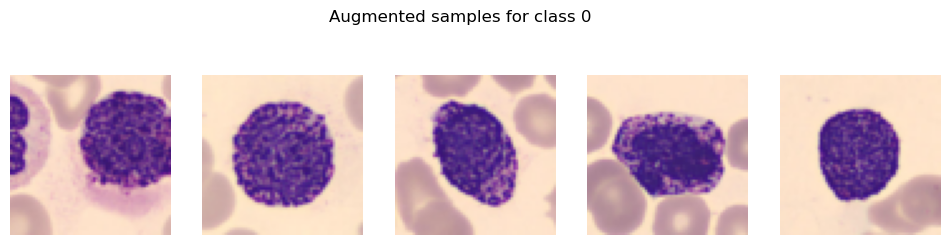

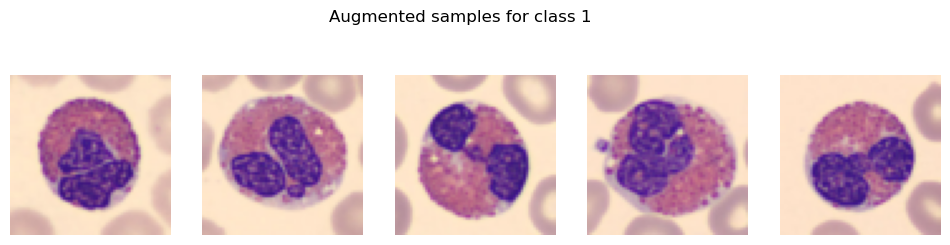

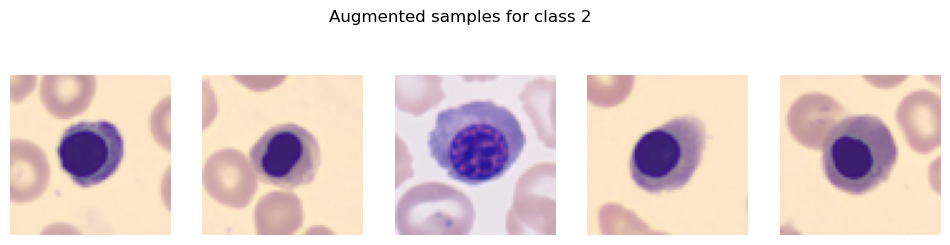

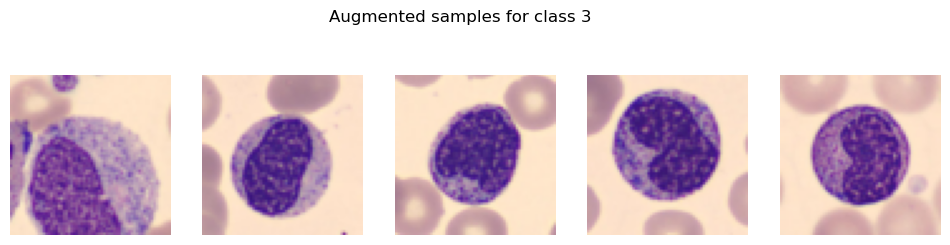

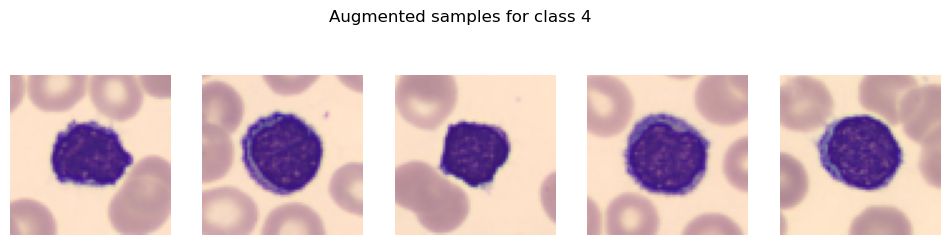

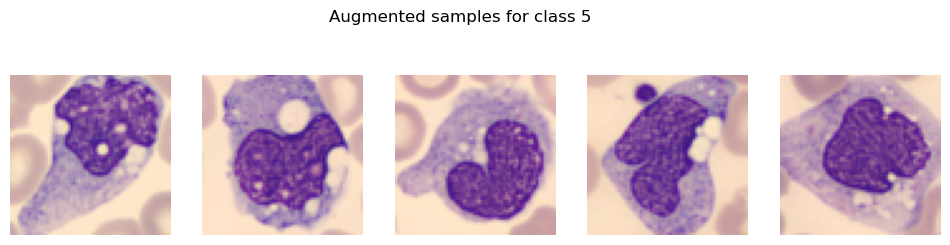

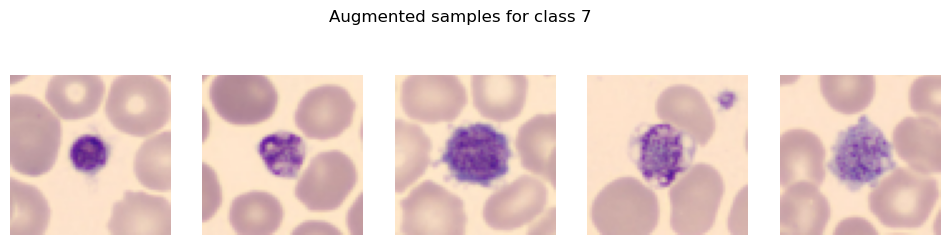

Final Class Distribution After Augmentation: {0: 2330, 1: 2330, 2: 2330, 3: 2330, 4: 2330, 5: 2330, 6: 2330, 7: 2330}


In [9]:
train_images_augm, train_labels_augm = create_train_set(train_images, train_labels)

In [10]:
# Create val/test datasets keeping the original class distribution
def create_test_set(test_images, test_labels):
    """
    Normalizes images and one-hot encodes labels.

    Args:
        test_images (numpy array): Test images of shape (_num of instances_, 64, 64, 3).
        test_labels (numpy array): Test labels of shape (_num of instances_, 1).

    Returns:
        test_images (numpy array): Normalized images.
        test_labels (numpy array): One-hot encoded labels.
    """

    # Normalize images
    test_images = test_images.astype("float32") / 255.0

    # Flatten labels from shape (11959, 1) -> (11959,)
    test_labels = test_labels.flatten()

    # One-hot encode labels
    unique_labels = np.unique(train_labels, return_counts=False)
    test_labels = to_categorical(test_labels, num_classes=len(unique_labels))

    # Shuffle
    test_images, test_labels = shuffle(test_images, test_labels, random_state=42)

    return test_images, test_labels


In [11]:
val_images_prepared, val_labels_prepared = create_test_set(val_images, val_labels)
test_images_prepared, test_labels_prepared = create_test_set(test_images, test_labels)
print('Validation and Test Sets are prepared.')

Validation and Test Sets are prepared.


Since all the models will be tested both on Original and Augmented Datasets, the Original Images must be normalized and the Original Labels must be One-Hot-Encoded.

In [12]:
# Normalize the Original Dataset Images
train_images = train_images.astype("float32") / 255.0
val_images = val_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0
# One-hot-encode the labels
train_labels = train_labels.astype(np.int32).flatten()
val_labels = val_labels.astype(np.int32).flatten()
test_labels = test_labels.astype(np.int32).flatten()

train_labels = to_categorical(train_labels, num_classes = 8)
val_labels = to_categorical(val_labels, num_classes = 8)
test_labels = to_categorical(test_labels, num_classes = 8)

## 4. Evaluation and Visualization Functions Preparation


The function `evaluate_model_performance()` evaluates a trained Keras model on a Test set for a multi-class image classification task. 
It takes as input:
- The trained Keras model
- Test images on which the `predict` method is used
- The correct Test Labels to compare the predictions of the model with. 

It computes and displays:
- Overall accuracy, weighted F1-score, precision, and recall
- A detailed classification report per class
- The confusion matrix

It also returns:
- Dictionary of summary metrics
- DataFrame of the full classification report (for further analysis or visualization)

The function `plot_learing_curves()` takes history of the training process of the model and plots **Loss Plot** and **Accuracy Plot** for Training and Validation Set, that were collected during the training process.

In [ ]:
def evaluate_model_performance(model, test_images, test_labels, class_names=['class0', 'class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7']):
    """
    Evaluates the performance of a TensorFlow/Keras model on a test set
    for a multi-class image classification problem.
    """
    y_pred = model.predict(test_images)
    y_pred_labels = np.argmax(y_pred, axis=1)

    if test_labels.ndim > 1 and test_labels.shape[1] > 1:
        test_labels = np.argmax(test_labels, axis=1)

    # Calculate metrics for the predictions of the model
    metrics = {
        'accuracy': accuracy_score(test_labels, y_pred_labels),
        'weighted_f1': f1_score(test_labels, y_pred_labels, average='weighted'),
        'weighted_recall': recall_score(test_labels, y_pred_labels, average='weighted'),
        'weighted_precision': precision_score(test_labels, y_pred_labels, average='weighted'),
        'confusion_matrix': confusion_matrix(test_labels, y_pred_labels)
    }

    unique_labels = list(np.unique(test_labels))
    
    print("Detailed Classification Report:")
    per_class_report = classification_report(test_labels, y_pred_labels, labels=sorted(unique_labels), target_names=class_names, output_dict=True)
    print(classification_report(test_labels, y_pred_labels, labels=sorted(unique_labels), target_names=class_names, output_dict=False))
    df_per_class_report = pd.DataFrame(per_class_report).transpose().round(4)


    # Print summary metrics
    print(f'Test Accuracy: {metrics["accuracy"]*100:.2f}%')
    print(f'Weighted F1 Score: {metrics["weighted_f1"]:.4f}')
    print(f'Weighted Recall: {metrics["weighted_recall"]:.4f}')
    print(f'Weighted Precision: {metrics["weighted_precision"]:.4f}')

    return metrics, df_per_class_report

In [14]:
def plot_learing_curves(history, model_name):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color="#97dbd0", linewidth=2)
    plt.plot(history.history['val_loss'], label='Val Loss', color="#5d25eb", linewidth=2)
    plt.title(f'{model_name} - Loss Plot', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    #plt.ylim(0, 1)
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color="#97dbd0", linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', color="#5d25eb", linewidth=2)

    plt.title(f'{model_name} - Accuracy Plot', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [15]:
results_df = pd.DataFrame(columns=[
    "Model_Name", "Test Accuracy (%)", "Weighted F1 Score", "Weighted Recall", "Weighted Precision", "Training Time (sec)", "CPU Usage (%)", "Memory Usage (MB)"
])

def collect_model_results(df, metrics, time_res, cpu_res, memory_res, model_name):
    df.loc[len(df)] = [
        model_name,
        round(metrics["accuracy"]*100, 2),
        round(metrics['weighted_f1'], 4),
        round(metrics['weighted_recall'], 4),
        round(metrics['weighted_precision'], 4),
        int(time_res),
        round(cpu_res, 4),
        memory_res
    ]
    return df
                           


## 5. Machine Learning Models

### 5.1 Model Training Configuration

This section defines the training setup for the deep learning models, including image shape, hyperparameters, callbacks, learning rate schedules, and optimizers.

#### 5.1.1 Input and Training Parameters
- **Image Shape:** `64 × 64 × 3` (RGB images)
- **Epochs:** 25
- **Batch Size:** 64
- **Base Learning Rate:** `0.0001` (for fixed LR optimizer)

#### 5.1.2 Callbacks
Callbacks are used to monitor training and adaptively manage the learning process.

- **EarlyStopping (patience=5):** Stops training if validation loss doesn’t improve for 5 epochs and restores best weights.
- **EarlyStopping (patience=10):** A more lenient variant with patience of 10 epochs, used in longer training scenarios.
- **ReduceLROnPlateau:** Reduces learning rate by a factor of 0.5 if validation loss plateaus for 3 epochs, with a minimum LR threshold of `1e-6`.

#### 5.1.3 Optimizer
- **Adam (Fixed LR):** Adaptive learning rate optimization with a constant learning rate of `0.0001`.

These settings enable experimentation with both adaptive and classic optimization strategies to assess performance trade-offs.


In [ ]:
IMG_SHAPE = (64, 64, 3)
NUM_EPOCHS = 25
BATCH_SIZE = 64

# Initiate the Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

early_stopping_10 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=3,
    min_lr=1e-6)

# Set the Optimizer
# Adam with fixed learning rate
adam_fix = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)



### 5.2 Models Architectures


#### 5.2.1 Baseline CNN Model – `create_basic_cnn_model()`

This function defines a **simple baseline Convolutional Neural Network (CNN)** for multi-class image classification tasks.

**Architecture:**
- **Input:** Image of shape `input_shape`
- **Conv Block 1:**
  - `Conv2D`: 16 filters, 3×3 kernel, padding = 'same' 
  - `ReLU` : Activation Layer
  - `MaxPooling2D`: 2×2 pool size
- **Conv Block 2:**
  - `Conv2D`: 32 filters, 3×3 kernel, padding = 'same' 
  - `ReLU` : Activation Layer
  - `MaxPooling2D`: 2×2 pool size
- **Fully Connected Layers:**
  - `Flatten`: Flattens the output from convolutional layers
  - `Dense`: 64 units with ReLU activation
  - `Dense`: Final softmax layer with `n_classes` outputs for multi-class classification



In [17]:
# Baseline CNN Model Definition
def create_baseline_cnn_model(input_shape, n_classes):
    model = models.Sequential([layers.Conv2D(16, (3,3), strides= (1,1), padding = 'same', activation = None, input_shape = input_shape),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size=2),
                               
                               layers.Conv2D(32, (3,3), strides = (1,1), padding = 'same', activation = None),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size=2),
                               
                               layers.Flatten(),
                               layers.Dense(64, activation='relu'),
                               layers.Dense(n_classes, activation='softmax')])
    return model

# Create model
baseline_cnn_model = create_baseline_cnn_model(input_shape=IMG_SHAPE, n_classes=NUM_CLASSES)

# Print Model Summary
baseline_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 activation (Activation)     (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                   

In [18]:
# ORIGINAL DATASET
# Compile model
baseline_cnn_model.compile(
    optimizer= adam_fix,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_time_start = time.time()

# Train the model on the initial datasets
history_baseline_cnn_model = baseline_cnn_model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping, reduce_lr],
    shuffle=True
)

baseline_cnn_total_time = time.time() - total_time_start
baseline_cnn_cpu_usage = psutil.cpu_percent(interval=1)

print("---Model Training is done---")
print(f'Time spent on training the baseline CNN model - Original Dataset: {int(baseline_cnn_total_time)} seconds, \n CPU Usage: {baseline_cnn_cpu_usage}%')


Epoch 1/25
187/187 [==============================] - 6s 29ms/step - loss: 1.6269 - accuracy: 0.4256 - val_loss: 1.2429 - val_accuracy: 0.6046 - lr: 1.0000e-04
Epoch 2/25
187/187 [==============================] - 5s 28ms/step - loss: 1.0555 - accuracy: 0.6570 - val_loss: 0.8829 - val_accuracy: 0.7079 - lr: 1.0000e-04
Epoch 3/25
187/187 [==============================] - 5s 28ms/step - loss: 0.8199 - accuracy: 0.7369 - val_loss: 0.7167 - val_accuracy: 0.7780 - lr: 1.0000e-04
Epoch 4/25
187/187 [==============================] - 5s 28ms/step - loss: 0.7026 - accuracy: 0.7772 - val_loss: 0.6407 - val_accuracy: 0.7926 - lr: 1.0000e-04
Epoch 5/25
187/187 [==============================] - 5s 28ms/step - loss: 0.6243 - accuracy: 0.7998 - val_loss: 0.5689 - val_accuracy: 0.8201 - lr: 1.0000e-04
Epoch 6/25
187/187 [==============================] - 5s 28ms/step - loss: 0.5653 - accuracy: 0.8194 - val_loss: 0.5353 - val_accuracy: 0.8213 - lr: 1.0000e-04
Epoch 7/25
187/187 [====================

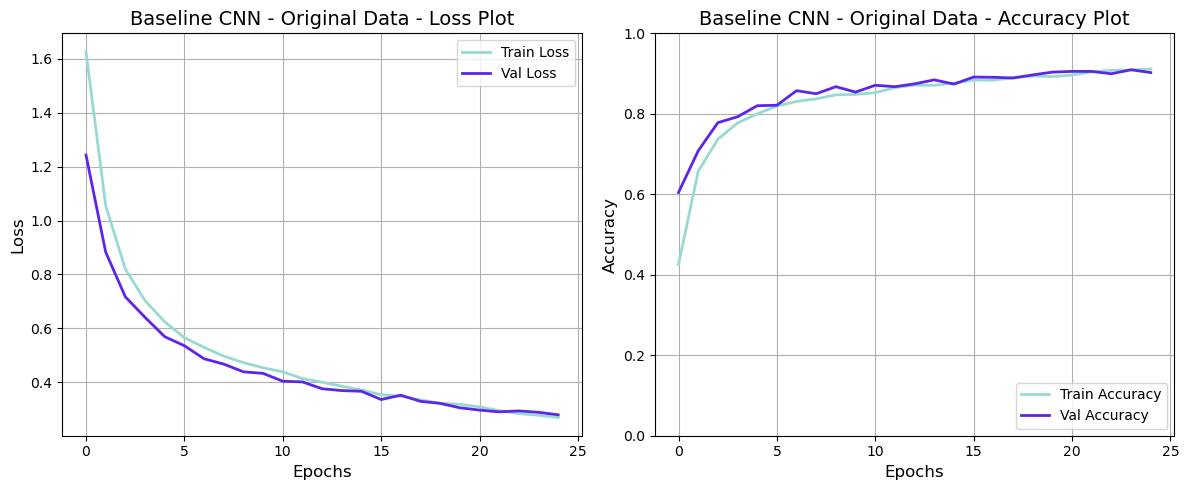

In [19]:
plot_learing_curves(history_baseline_cnn_model, model_name='Baseline CNN - Original Data')

In [20]:
baseline_cnn_model_performance = evaluate_model_performance(baseline_cnn_model, test_images, test_labels)

107/107 [==============================] - 1s 6ms/step
Detailed Classification Report:
              precision    recall  f1-score   support

      class0       0.94      0.86      0.90       244
      class1       0.95      0.98      0.96       624
      class2       0.84      0.85      0.84       311
      class3       0.79      0.83      0.81       579
      class4       0.92      0.87      0.90       243
      class5       0.86      0.79      0.82       284
      class6       0.95      0.94      0.94       666
      class7       0.97      0.99      0.98       470

    accuracy                           0.90      3421
   macro avg       0.90      0.89      0.89      3421
weighted avg       0.90      0.90      0.90      3421

Test Accuracy: 90.35%
Weighted F1 Score: 0.9034
Weighted Recall: 0.9035
Weighted Precision: 0.9040


In [21]:
results_df = collect_model_results(results_df, baseline_cnn_model_performance[0], baseline_cnn_total_time, baseline_cnn_cpu_usage, memory_res = '2.02', model_name='Baseline CNN - Original Data')
results_df

,Model_Name,Test Accuracy (%),Weighted F1 Score,Weighted Recall,Weighted Precision,Training Time (sec),CPU Usage (%),Memory Usage (MB)
0,Baseline CNN - Original Data,90.35,0.9034,0.9035,0.904,131,12.1,2.02


In [22]:
# AUGMENTED DATASET
# Create model
baseline_cnn_model_augm = create_baseline_cnn_model(input_shape=IMG_SHAPE, n_classes=NUM_CLASSES)

# Compile model
baseline_cnn_model_augm.compile(
    optimizer= adam_fix,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_time_start = time.time()

# Train the model
history_baseline_cnn_augm_model = baseline_cnn_model_augm.fit(
    train_images_augm, train_labels_augm,
    validation_data=(val_images_prepared, val_labels_prepared),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping, reduce_lr],
    shuffle=True
)
baseline_cnn_augm_total_time = time.time() - total_time_start
baseline_cnn_augm_cpu_usage = psutil.cpu_percent(interval=1)

print("---Model Training is done---")
print(f'Time spent on training the baseline CNN model - Augm Dataset: {int(baseline_cnn_augm_total_time)} seconds, \n CPU Usage: {baseline_cnn_augm_cpu_usage}%')

Epoch 1/25
292/292 [==============================] - 8s 27ms/step - loss: 1.0162 - accuracy: 0.6415 - val_loss: 0.7110 - val_accuracy: 0.7512 - lr: 1.0000e-04
Epoch 2/25
292/292 [==============================] - 7s 25ms/step - loss: 0.6942 - accuracy: 0.7732 - val_loss: 0.5976 - val_accuracy: 0.8172 - lr: 1.0000e-04
Epoch 3/25
292/292 [==============================] - 7s 25ms/step - loss: 0.5839 - accuracy: 0.8121 - val_loss: 0.5266 - val_accuracy: 0.8294 - lr: 1.0000e-04
Epoch 4/25
292/292 [==============================] - 8s 27ms/step - loss: 0.5042 - accuracy: 0.8381 - val_loss: 0.4378 - val_accuracy: 0.8616 - lr: 1.0000e-04
Epoch 5/25
292/292 [==============================] - 9s 32ms/step - loss: 0.4527 - accuracy: 0.8535 - val_loss: 0.4445 - val_accuracy: 0.8569 - lr: 1.0000e-04
Epoch 6/25
292/292 [==============================] - 8s 28ms/step - loss: 0.4124 - accuracy: 0.8632 - val_loss: 0.3802 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 7/25
292/292 [====================

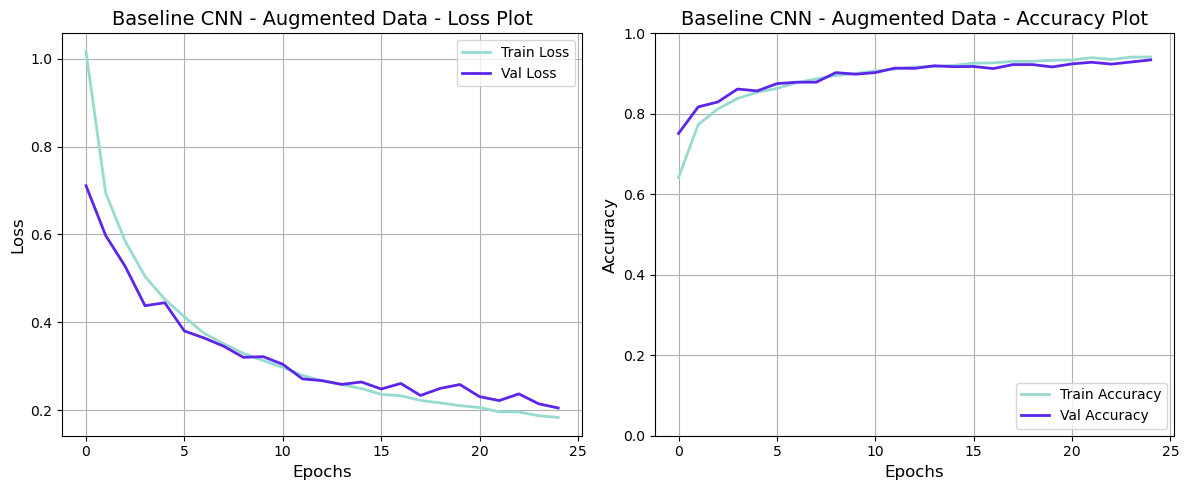

In [23]:
plot_learing_curves(history_baseline_cnn_augm_model, model_name='Baseline CNN - Augmented Data')

In [24]:
baseline_cnn_model_augm_performance = evaluate_model_performance(baseline_cnn_model_augm, test_images_prepared, test_labels_prepared)

107/107 [==============================] - 1s 5ms/step
Detailed Classification Report:
              precision    recall  f1-score   support

      class0       0.89      0.94      0.92       244
      class1       0.97      0.97      0.97       624
      class2       0.91      0.94      0.92       311
      class3       0.81      0.89      0.85       579
      class4       0.97      0.87      0.92       243
      class5       0.92      0.83      0.87       284
      class6       0.97      0.93      0.95       666
      class7       1.00      0.98      0.99       470

    accuracy                           0.93      3421
   macro avg       0.93      0.92      0.92      3421
weighted avg       0.93      0.93      0.93      3421

Test Accuracy: 92.81%
Weighted F1 Score: 0.9287
Weighted Recall: 0.9281
Weighted Precision: 0.9312


In [25]:
results_df = collect_model_results(results_df, baseline_cnn_model_augm_performance[0], baseline_cnn_augm_total_time, baseline_cnn_augm_cpu_usage, memory_res='2.02', model_name='Baseline CNN - Augm Data')
results_df

,Model_Name,Test Accuracy (%),Weighted F1 Score,Weighted Recall,Weighted Precision,Training Time (sec),CPU Usage (%),Memory Usage (MB)
0,Baseline CNN - Original Data,90.35,0.9034,0.9035,0.9040,131,12.1,2.02
1,Baseline CNN - Augm Data,92.81,0.9287,0.9281,0.9312,194,10.9,2.02


#### 5.2.2 Baseline CNN + Batch Normalization

To the initial Baseline Model Batch Normalization Layers were added in order to improve the performance of the model.

**Architecture:**

- **Input:** Image of shape `input_shape`.

- **Conv Block 1:**
  - `Conv2D`: 16 filters, 3×3 kernel, stride 1, padding = "same"
  - `BatchNormalization`
  - `ReLU`: Activation Layer
  - `MaxPooling2D`: Pool size 2×2

- **Conv Block 2:**
  - `Conv2D`: 32 filters, 3×3 kernel, stride 1, padding = "same"
  - `BatchNormalization`
  - `ReLU`: Activation Layer
  - `MaxPooling2D`: Pool size 2×2

- **Fully Connected Layers:**
  - `Flatten`: Flattens the output from convolutional layers
  - `Dense`: 64 units with ReLU activation
  - `Dense`: Final softmax layer with `n_classes` outputs for multi-class classification


In [26]:
def create_cnn_model_batch_norm(input_shape, n_classes):
    model = tf.keras.Sequential([layers.Conv2D(16, (3,3), strides= (1,1), padding = 'same', activation = None, input_shape = input_shape),
                                 layers.BatchNormalization(),
                                 layers.Activation('relu'),
                                 layers.MaxPool2D((2,2), strides = (2,2), padding = 'same'),

                                 layers.Conv2D(32, (3,3), strides = (1,1), padding = 'same', activation = None),
                                 layers.BatchNormalization(),
                                 layers.Activation('relu'),
                                 layers.MaxPool2D((2,2), strides = (2,2), padding = 'same'),
                                 
                                 layers.Flatten(),
                                 layers.Dense(64, activation='relu'),
                                 layers.Dense(n_classes, activation='softmax')])
    return model

# Create model
cnn_model_batch_norm = create_cnn_model_batch_norm(input_shape=IMG_SHAPE, n_classes=NUM_CLASSES)

# Print Model Summary
cnn_model_batch_norm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 16)        64        
 Normalization)                                                  
                                                                 
 activation_4 (Activation)   (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)       

In [27]:
# ORIGINAL DATASET
# Compile model
cnn_model_batch_norm.compile(
    optimizer= adam_fix,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_time_start = time.time()

# Train the model on the original datasets
history_cnn_model_batch_norm = cnn_model_batch_norm.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping, reduce_lr],
    shuffle=True
)
cnn_model_batch_norm_total_time = time.time() - total_time_start
cnn_model_batch_norm_cpu_usage = psutil.cpu_percent(interval=1)

print("---Model Training is done---")
print(f'Time spent on training the CNN w/Batch Normalization - Original Data: {int(cnn_model_batch_norm_total_time)} seconds, \n CPU Usage: {cnn_model_batch_norm_cpu_usage}%')

Epoch 1/25
187/187 [==============================] - 7s 37ms/step - loss: 0.5808 - accuracy: 0.7992 - val_loss: 4.4439 - val_accuracy: 0.1373 - lr: 1.0000e-04
Epoch 2/25
187/187 [==============================] - 7s 36ms/step - loss: 0.2743 - accuracy: 0.9062 - val_loss: 1.5747 - val_accuracy: 0.4562 - lr: 1.0000e-04
Epoch 3/25
187/187 [==============================] - 7s 37ms/step - loss: 0.2149 - accuracy: 0.9277 - val_loss: 0.2787 - val_accuracy: 0.9013 - lr: 1.0000e-04
Epoch 4/25
187/187 [==============================] - 7s 37ms/step - loss: 0.1697 - accuracy: 0.9463 - val_loss: 0.1887 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 5/25
187/187 [==============================] - 7s 37ms/step - loss: 0.1489 - accuracy: 0.9507 - val_loss: 0.1656 - val_accuracy: 0.9428 - lr: 1.0000e-04
Epoch 6/25
187/187 [==============================] - 7s 37ms/step - loss: 0.1251 - accuracy: 0.9635 - val_loss: 0.1844 - val_accuracy: 0.9352 - lr: 1.0000e-04
Epoch 7/25
187/187 [====================

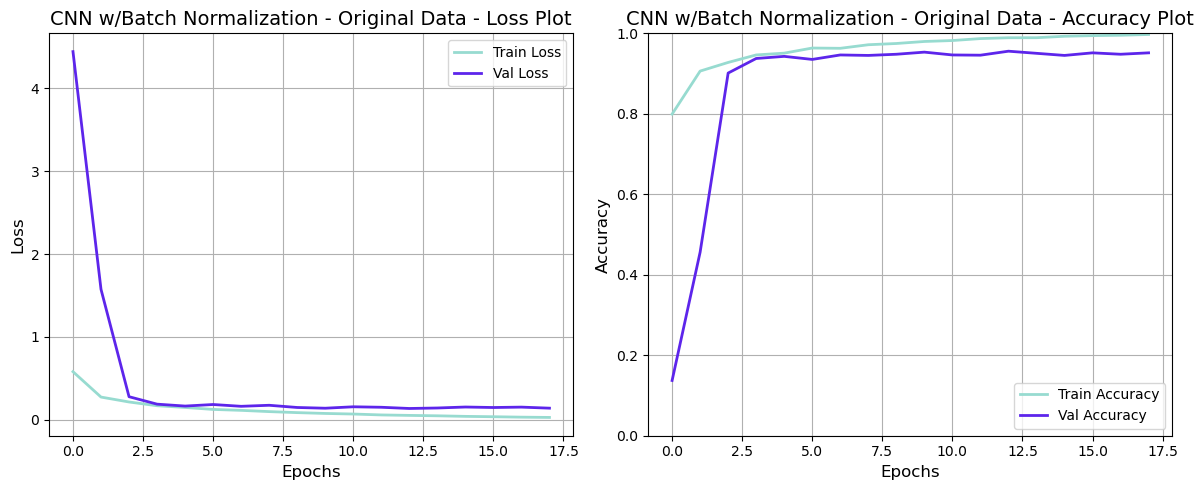

In [28]:
plot_learing_curves(history_cnn_model_batch_norm, model_name='CNN w/Batch Normalization - Original Data')

In [29]:
cnn_model_batch_norm_performance = evaluate_model_performance(cnn_model_batch_norm, test_images, test_labels)

107/107 [==============================] - 1s 7ms/step
Detailed Classification Report:
              precision    recall  f1-score   support

      class0       0.94      0.96      0.95       244
      class1       0.99      0.99      0.99       624
      class2       0.93      0.97      0.95       311
      class3       0.88      0.89      0.88       579
      class4       0.96      0.96      0.96       243
      class5       0.93      0.87      0.90       284
      class6       0.96      0.95      0.95       666
      class7       1.00      1.00      1.00       470

    accuracy                           0.95      3421
   macro avg       0.95      0.95      0.95      3421
weighted avg       0.95      0.95      0.95      3421

Test Accuracy: 94.88%
Weighted F1 Score: 0.9488
Weighted Recall: 0.9488
Weighted Precision: 0.9490


In [30]:
results_df = collect_model_results(results_df, cnn_model_batch_norm_performance[0], cnn_model_batch_norm_total_time, cnn_model_batch_norm_cpu_usage, memory_res='2.02', model_name='CNN w/BatchNorm - Original Data')
results_df

,Model_Name,Test Accuracy (%),Weighted F1 Score,Weighted Recall,Weighted Precision,Training Time (sec),CPU Usage (%),Memory Usage (MB)
0,Baseline CNN - Original Data,90.35,0.9034,0.9035,0.9040,131,12.1,2.02
1,Baseline CNN - Augm Data,92.81,0.9287,0.9281,0.9312,194,10.9,2.02
2,CNN w/BatchNorm - Original Data,94.88,0.9488,0.9488,0.9490,126,7.6,2.02


In [31]:
# AUGMENTED DATASET
# Create the model
cnn_model_batch_norm_augm = create_cnn_model_batch_norm(input_shape=IMG_SHAPE, n_classes=NUM_CLASSES)
# Compile the model
cnn_model_batch_norm_augm.compile(
    optimizer=adam_fix,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_time_start = time.time()
# Train the model on the augmented dataset
history_cnn_model_batch_norm_augm = cnn_model_batch_norm_augm.fit(
    train_images_augm, train_labels_augm,
    validation_data=(val_images_prepared, val_labels_prepared),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping, reduce_lr],
    shuffle=True
)

cnn_model_batch_norm_augm_total_time = time.time() - total_time_start
cnn_model_batch_norm_augm_cpu_usage = psutil.cpu_percent(interval=1)

print("---Model Training is done---")
print(f'Time spent on training the CNN w/Batch Normalization - Augm Data: {int(cnn_model_batch_norm_augm_total_time)} seconds, \n CPU Usage: {cnn_model_batch_norm_augm_cpu_usage}%')

Epoch 1/25
292/292 [==============================] - 11s 36ms/step - loss: 0.6260 - accuracy: 0.7909 - val_loss: 2.1953 - val_accuracy: 0.3364 - lr: 5.0000e-05
Epoch 2/25
292/292 [==============================] - 10s 36ms/step - loss: 0.2883 - accuracy: 0.9116 - val_loss: 0.3775 - val_accuracy: 0.8639 - lr: 5.0000e-05
Epoch 3/25
292/292 [==============================] - 11s 37ms/step - loss: 0.2219 - accuracy: 0.9308 - val_loss: 0.2404 - val_accuracy: 0.9194 - lr: 5.0000e-05
Epoch 4/25
292/292 [==============================] - 12s 40ms/step - loss: 0.1830 - accuracy: 0.9439 - val_loss: 0.2022 - val_accuracy: 0.9357 - lr: 5.0000e-05
Epoch 5/25
292/292 [==============================] - 11s 37ms/step - loss: 0.1589 - accuracy: 0.9518 - val_loss: 0.2056 - val_accuracy: 0.9328 - lr: 5.0000e-05
Epoch 6/25
292/292 [==============================] - 11s 37ms/step - loss: 0.1420 - accuracy: 0.9580 - val_loss: 0.1848 - val_accuracy: 0.9410 - lr: 5.0000e-05
Epoch 7/25
292/292 [==============

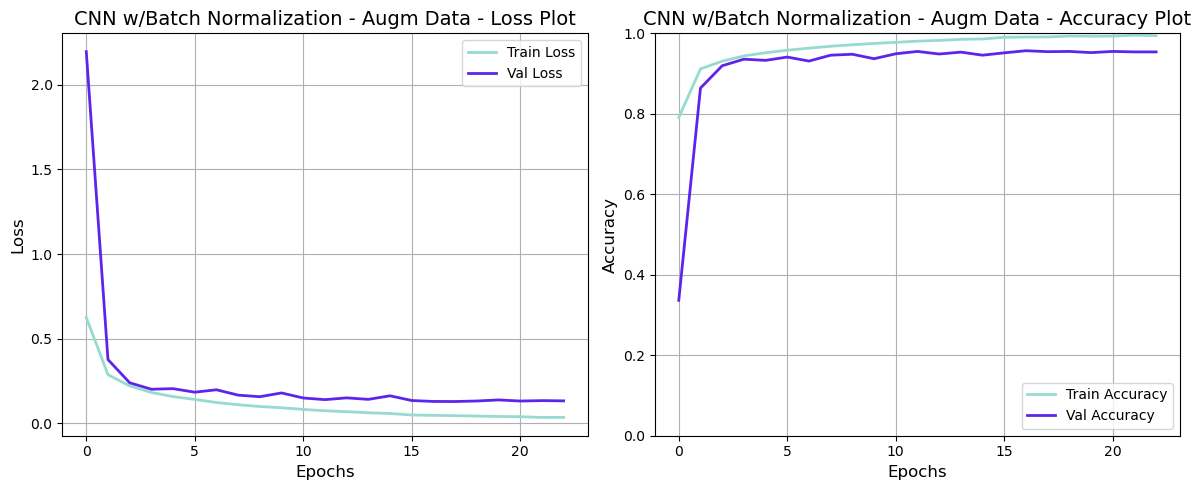

In [32]:
plot_learing_curves(history_cnn_model_batch_norm_augm, model_name='CNN w/Batch Normalization - Augm Data')

In [33]:
cnn_model_batch_norm_performance_augm = evaluate_model_performance(cnn_model_batch_norm_augm, test_images_prepared, test_labels_prepared)

107/107 [==============================] - 1s 7ms/step
Detailed Classification Report:
              precision    recall  f1-score   support

      class0       0.93      0.97      0.95       244
      class1       0.98      0.99      0.99       624
      class2       0.97      0.97      0.97       311
      class3       0.91      0.88      0.89       579
      class4       0.95      0.96      0.96       243
      class5       0.90      0.92      0.91       284
      class6       0.96      0.96      0.96       666
      class7       1.00      1.00      1.00       470

    accuracy                           0.96      3421
   macro avg       0.95      0.96      0.95      3421
weighted avg       0.96      0.96      0.96      3421

Test Accuracy: 95.53%
Weighted F1 Score: 0.9551
Weighted Recall: 0.9553
Weighted Precision: 0.9551


In [34]:
results_df = collect_model_results(results_df, cnn_model_batch_norm_performance_augm[0], cnn_model_batch_norm_augm_total_time, cnn_model_batch_norm_augm_cpu_usage, memory_res='2.02', model_name='CNN w/BatchNorm - Augm Data')
results_df

,Model_Name,Test Accuracy (%),Weighted F1 Score,Weighted Recall,Weighted Precision,Training Time (sec),CPU Usage (%),Memory Usage (MB)
0,Baseline CNN - Original Data,90.35,0.9034,0.9035,0.9040,131,12.1,2.02
1,Baseline CNN - Augm Data,92.81,0.9287,0.9281,0.9312,194,10.9,2.02
2,CNN w/BatchNorm - Original Data,94.88,0.9488,0.9488,0.9490,126,7.6,2.02
3,CNN w/BatchNorm - Augm Data,95.53,0.9551,0.9553,0.9551,250,10.5,2.02


#### 5.2.3 ResNet-inspired Model - CNN Model with Skip Connections

This model architecture incorporates **skip connections**, a concept popularized by ResNet (Residual Networks). The core idea of skip connections is to **allow the input of a layer to be directly added to the output of a deeper layer**, bypassing intermediate transformations. This helps alleviate the **vanishing gradient problem**, enables **deeper network architectures**, and allows for **better feature propagation** during training.

This model incorporates custom **Skip-Connection Block**.

**Skip-Connection Block:**

The `skip_block` defines a residual block with two convolutional layers and an identity (or projection) shortcut connection:

- **Main Path:**
  - Two `Conv2D` layers, each followed by Batch Normalization and ReLU activation.
  - Optional downsampling via stride (used when `skip_conv=True`).

- **Skip Connection:**
  - If the input and output dimensions differ (due to stride or filter size), a 1×1 convolution is applied to the skip path to match shapes.

- **Element-wise Addition:**
  - The output of the main path is added to the transformed input (skip path), and a final ReLU activation is applied.


**Model Architecture:**

- **ZeroPadding**: adds zero-padding of 3 pixels to each side

- **Initial Convolution + Pooling:**
   - `Conv2D`: 32 filters, 3×3 kernel, padding = 'same'
   - `BatchNormalization`
   - `ReLU` Activation
   - `MaxPooling`: 3×3 pool size, 2×2 strides

- **Residual Blocks:**
   - **Block 1:** Two skip blocks with 32 filters, followed by `Dropout` Layer (20%)
   - **Block 2:** Two skip blocks with 64 filters, the first block with projection (skip_conv=True), followed by `Dropout` Layer (20%)
   - **Block 3:** Two skip blocks with 128 filters, the first block with projection (skip_conv=True), followed by `Dropout` Layer (20%)

- **Pooling and Dense Layers:**
   - `Global Average Pooling`
   - `Dense`: 64 units, `ReLU` Axtivation
   - `Dropout`: 30% Dropout Rate
   - `Dense`: final layer with `num_classes` neurons and `sofmax` Actvation.


In [35]:
def skip_block(x, filters, skip_conv=False):
    # Saving input for skip connection
    x_skip = x
    # 
    strides = (2,2) if skip_conv == True else (1,1)

    # Layer 1
    x = layers.Conv2D(filters, kernel_size = (3,3), strides = strides, padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # Layer 2
    x = layers.Conv2D(filters, kernel_size = (3,3), strides = (1,1), padding = 'same')(x)
    x = layers.BatchNormalization()(x)

    if x.shape[-1] != x_skip.shape[-1] or skip_conv == True:
        x_skip = layers.Conv2D(filters, (1,1), strides=strides, padding='same')(x_skip)
        x_skip = layers.BatchNormalization()(x_skip)

    # Add Skip Connection
    x = layers.Add()([x, x_skip])     
    x = layers.Activation('relu')(x)
    return x

def create_skip_con_model(input_shape, num_classes):
    X_input = Input(input_shape)

    X = layers.ZeroPadding2D((3, 3))(X_input)

    X = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(X)

    # 1st convolutional block
    X = skip_block(X, filters=32)
    X = skip_block(X, filters=32)
    X = layers.Dropout(0.2)(X)
    # 2nd Block
    X = skip_block(X, filters=64, skip_conv=True)
    X = skip_block(X, filters=64)
    X = layers.Dropout(0.2)(X)
    # 3rd Block
    X = skip_block(X, filters=128, skip_conv=True)
    X = skip_block(X, filters=128)
    X = layers.Dropout(0.2)(X)

    # Pooling layers
    X = layers.GlobalAveragePooling2D()(X)
    X = layers.Dense(64, activation = 'relu')(X)
    X = layers.Dropout(0.3)(X)

    # Output layer
    X = layers.Dense(num_classes, activation='softmax')(X)

    # Create model
    model = Model(inputs=X_input, outputs=X)

    return model




In [36]:
# Create the model
cnn_skip_connections = create_skip_con_model(input_shape = IMG_SHAPE, num_classes = NUM_CLASSES)

cnn_skip_connections.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 70, 70, 32)           896       ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization_4 (Bat  (None, 70, 70, 32)           128       ['conv2d_8[0][0]']        

In [38]:
# ORIGINAL DATASET
# Compile the model
cnn_skip_connections.compile(
    optimizer=adam_fix,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_time_start = time.time()
# Train the model on the original dataset
history_cnn_skip_connections = cnn_skip_connections.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping_10, reduce_lr],
    shuffle=True
)

cnn_skip_connections_total_time = time.time() - total_time_start
cnn_skip_connections_cpu_usage = psutil.cpu_percent(interval=1)

print("---Model Training is done---")
print(f'Time spent on training the CNN model w/Skip Connections - Original Data: {int(cnn_skip_connections_total_time)} seconds, \n CPU Usage: {cnn_skip_connections_cpu_usage}%')

Epoch 1/25
187/187 [==============================] - 50s 264ms/step - loss: 1.3545 - accuracy: 0.5290 - val_loss: 7.3669 - val_accuracy: 0.1373 - lr: 1.2500e-05
Epoch 2/25
187/187 [==============================] - 48s 258ms/step - loss: 0.7111 - accuracy: 0.7599 - val_loss: 5.2563 - val_accuracy: 0.2126 - lr: 1.2500e-05
Epoch 3/25
187/187 [==============================] - 49s 261ms/step - loss: 0.5392 - accuracy: 0.8192 - val_loss: 3.2904 - val_accuracy: 0.3937 - lr: 1.2500e-05
Epoch 4/25
187/187 [==============================] - 48s 255ms/step - loss: 0.4553 - accuracy: 0.8513 - val_loss: 0.6674 - val_accuracy: 0.7138 - lr: 1.2500e-05
Epoch 5/25
187/187 [==============================] - 48s 255ms/step - loss: 0.3970 - accuracy: 0.8743 - val_loss: 0.2676 - val_accuracy: 0.9095 - lr: 1.2500e-05
Epoch 6/25
187/187 [==============================] - 48s 256ms/step - loss: 0.3568 - accuracy: 0.8880 - val_loss: 0.2456 - val_accuracy: 0.9246 - lr: 1.2500e-05
Epoch 7/25
187/187 [========

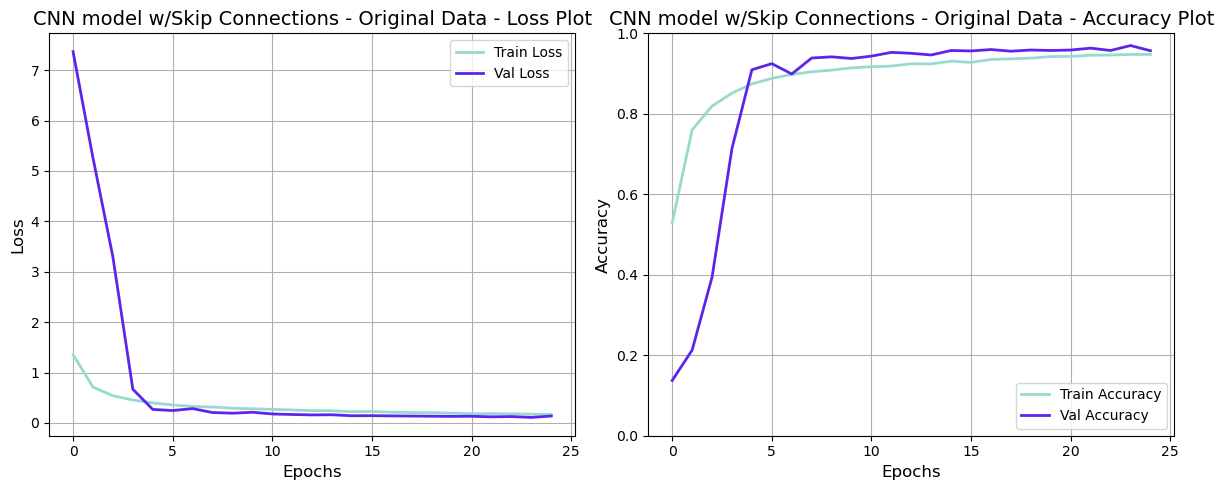

In [39]:
plot_learing_curves(history_cnn_skip_connections, model_name='CNN model w/Skip Connections - Original Data')

In [40]:
cnn_skip_connections_model_performance = evaluate_model_performance(cnn_skip_connections, test_images, test_labels)

107/107 [==============================] - 5s 47ms/step
Detailed Classification Report:
              precision    recall  f1-score   support

      class0       0.98      0.95      0.97       244
      class1       0.99      1.00      0.99       624
      class2       0.99      0.90      0.94       311
      class3       0.83      0.93      0.88       579
      class4       0.98      0.99      0.98       243
      class5       0.99      0.71      0.83       284
      class6       0.94      0.97      0.96       666
      class7       0.97      1.00      0.99       470

    accuracy                           0.95      3421
   macro avg       0.96      0.93      0.94      3421
weighted avg       0.95      0.95      0.95      3421

Test Accuracy: 94.59%
Weighted F1 Score: 0.9451
Weighted Recall: 0.9459
Weighted Precision: 0.9496


In [41]:
results_df = collect_model_results(results_df, cnn_skip_connections_model_performance[0], cnn_skip_connections_total_time, cnn_skip_connections_cpu_usage, memory_res='2.7', model_name='CNN model w/Skip Connections - Original Data')
results_df

,Model_Name,Test Accuracy (%),Weighted F1 Score,Weighted Recall,Weighted Precision,Training Time (sec),CPU Usage (%),Memory Usage (MB)
0,Baseline CNN - Original Data,90.35,0.9034,0.9035,0.9040,131,12.1,2.02
1,Baseline CNN - Augm Data,92.81,0.9287,0.9281,0.9312,194,10.9,2.02
2,CNN w/BatchNorm - Original Data,94.88,0.9488,0.9488,0.9490,126,7.6,2.02
3,CNN w/BatchNorm - Augm Data,95.53,0.9551,0.9553,0.9551,250,10.5,2.02
4,CNN model w/Skip Connections - Original Data,94.59,0.9451,0.9459,0.9496,1234,10.4,2.7


In [42]:
# AUGMENTED DATASET
# Create the model
cnn_skip_connections_augm = create_skip_con_model(input_shape = IMG_SHAPE, num_classes = NUM_CLASSES)
# Compile the model
cnn_skip_connections_augm.compile(
    optimizer=adam_fix,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_time_start = time.time()
# Train the model on the augmented dataset
history_cnn_skip_connections_augm = cnn_skip_connections_augm.fit(
    train_images_augm, train_labels_augm,
    validation_data=(val_images_prepared, val_labels_prepared),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping, reduce_lr],
    shuffle=True
)

cnn_skip_connections_augm_total_time = time.time() - total_time_start
cnn_skip_connections_augm_cpu_usage = psutil.cpu_percent(interval=1)

print("---Model Training is done---")
print(f'Time spent on training the CNN model w/Skip Connections - Augm Data: {int(cnn_skip_connections_augm_total_time)} seconds, \n CPU Usage: {cnn_skip_connections_augm_cpu_usage}%')

Epoch 1/25
292/292 [==============================] - 77s 262ms/step - loss: 1.1587 - accuracy: 0.5848 - val_loss: 7.0499 - val_accuracy: 0.1484 - lr: 1.2500e-05
Epoch 2/25
292/292 [==============================] - 77s 263ms/step - loss: 0.5553 - accuracy: 0.8193 - val_loss: 2.6621 - val_accuracy: 0.3575 - lr: 1.2500e-05
Epoch 3/25
292/292 [==============================] - 76s 259ms/step - loss: 0.4301 - accuracy: 0.8620 - val_loss: 0.4286 - val_accuracy: 0.8394 - lr: 1.2500e-05
Epoch 4/25
292/292 [==============================] - 78s 266ms/step - loss: 0.3809 - accuracy: 0.8794 - val_loss: 0.3369 - val_accuracy: 0.8779 - lr: 1.2500e-05
Epoch 5/25
292/292 [==============================] - 76s 259ms/step - loss: 0.3307 - accuracy: 0.8955 - val_loss: 0.3330 - val_accuracy: 0.8750 - lr: 1.2500e-05
Epoch 6/25
292/292 [==============================] - 80s 273ms/step - loss: 0.3057 - accuracy: 0.9042 - val_loss: 0.2497 - val_accuracy: 0.9118 - lr: 1.2500e-05
Epoch 7/25
292/292 [========

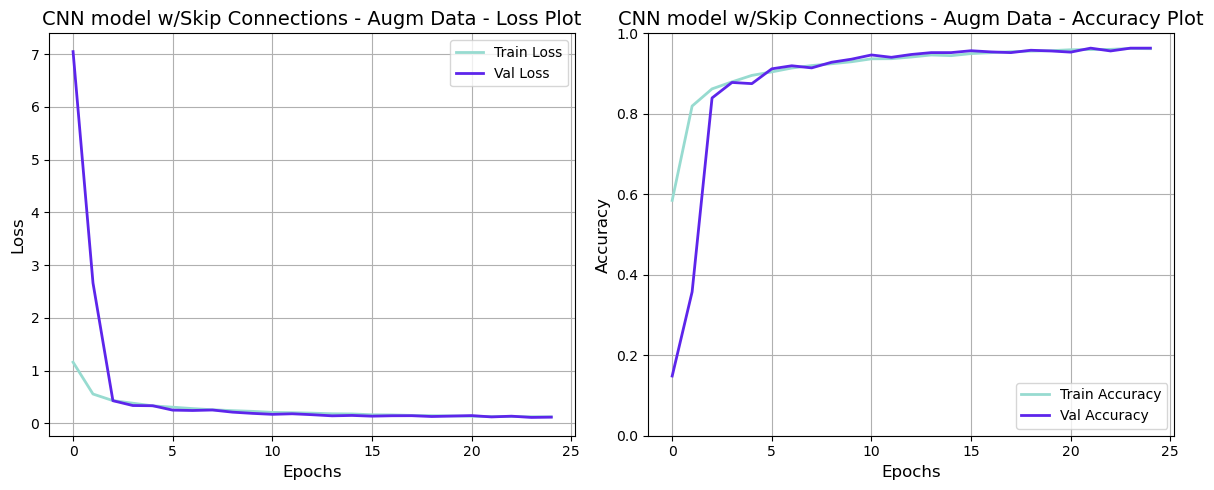

In [43]:
plot_learing_curves(history_cnn_skip_connections_augm, model_name='CNN model w/Skip Connections - Augm Data')

In [44]:
cnn_skip_connections_augm_model_performance = evaluate_model_performance(cnn_skip_connections_augm, test_images_prepared, test_labels_prepared)

107/107 [==============================] - 5s 49ms/step
Detailed Classification Report:
              precision    recall  f1-score   support

      class0       1.00      0.82      0.90       244
      class1       1.00      0.98      0.99       624
      class2       0.99      0.94      0.97       311
      class3       0.89      0.94      0.91       579
      class4       1.00      0.95      0.97       243
      class5       0.91      0.96      0.94       284
      class6       0.94      0.98      0.96       666
      class7       0.99      1.00      1.00       470

    accuracy                           0.96      3421
   macro avg       0.96      0.95      0.95      3421
weighted avg       0.96      0.96      0.96      3421

Test Accuracy: 95.76%
Weighted F1 Score: 0.9576
Weighted Recall: 0.9576
Weighted Precision: 0.9594


In [45]:
results_df = collect_model_results(results_df, cnn_skip_connections_augm_model_performance[0], cnn_skip_connections_augm_total_time, cnn_skip_connections_augm_cpu_usage, memory_res='2.7', model_name='CNN model w/Skip Connections - Augm Data')
results_df

,Model_Name,Test Accuracy (%),Weighted F1 Score,Weighted Recall,Weighted Precision,Training Time (sec),CPU Usage (%),Memory Usage (MB)
0,Baseline CNN - Original Data,90.35,0.9034,0.9035,0.9040,131,12.1,2.02
1,Baseline CNN - Augm Data,92.81,0.9287,0.9281,0.9312,194,10.9,2.02
2,CNN w/BatchNorm - Original Data,94.88,0.9488,0.9488,0.9490,126,7.6,2.02
3,CNN w/BatchNorm - Augm Data,95.53,0.9551,0.9553,0.9551,250,10.5,2.02
4,CNN model w/Skip Connections - Original Data,94.59,0.9451,0.9459,0.9496,1234,10.4,2.7
5,CNN model w/Skip Connections - Augm Data,95.76,0.9576,0.9576,0.9594,1955,17.0,2.7


#### 5.2.4 CNN + Attention Mechanism

Convolutional Neural Networks (CNNs) are highly effective at capturing local spatial patterns through hierarchical feature extraction. However, they inherently suffer from limited global context awareness due to their local receptive fields and fixed kernel operations.

To address this limitation, attention mechanisms can be integrated with CNNs. Attention enables the model to adaptively focus on the most relevant regions of an image, regardless of spatial distance, thereby improving the capture of long-range dependencies and semantic relationships.

The following functions `se_block` and `cbam_block` are introduced for future incorporation into CNN architecture. 



In [ ]:
def se_block(input, reduction):
    channels = input.shape[-1]
    # Squeeze: 
    x = layers.GlobalAveragePooling2D()(input)
    
    # Excitation: 
    x = layers.Dense(channels // reduction, activation='relu')(x)
    x = layers.Dense(channels, activation='sigmoid')(x)        
    
    # Scale and Combine: Apply weights to the channels by element-wise multiplication
    return layers.multiply([input, x])

In [47]:
def cbam_block(input, reduction=16):
    channels = input.shape[-1]
    kernel_size = 7
    # Channel Attention part
    # Perform MaxPooling and AveragePooling on the input tensor
    max_pool = layers.GlobalMaxPooling2D()(input)
    avg_pool = layers.GlobalAveragePooling2D()(input)

    # Define shared layers
    shared_layer_one = layers.Dense(channels//reduction,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
    shared_layer_two = layers.Dense(channels,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')

    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    ca_feature = layers.Add()([max_pool, avg_pool])
    ca_feature = layers.Activation('sigmoid') (ca_feature)
    ca_feature = layers.Reshape((1, 1, channels))(ca_feature)

    ca_output = layers.Multiply()([input, ca_feature])

    # Spatial Attention Part
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(ca_output)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(ca_output)

    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])

    cbam_feature = layers.Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)
    
    output = layers.Multiply()([input, cbam_feature])
    return output


#### 5.2.4.1 CNN + CBAM Attention

**Architecture:**

- **Input:** Image of shape `input_shape`.

- **Conv Block:**
  - `Conv2D`: 32 filters, 3×3 kernel, stride 1, padding = "same"
  - `BatchNormalization`
  - `ReLU`: Activation Layer
- **CBAM Block**
- `MaxPool`: Pool size 2×2
- `Dropout`: Dropout rate 25%

- **Conv Block:**
  - `Conv2D`: 64 filters, 3×3 kernel, stride 1, padding = "same"
  - `BatchNormalization`
  - `ReLU`: Activation Layer
- **CBAM Block**
- `MaxPool`: Pool size 2×2
- `Dropout`: Dropout rate 25%

- **Conv Block:**
  - `Conv2D`: 128 filters, 3×3 kernel, stride 1, padding = "same"
  - `BatchNormalization`
  - `ReLU`: Activation Layer
- `CBAM Block`
- `GlobalAveragePooling`

- **Fully Connected Layers:**
  - `Dense`: Two `Dense` Layers with 128 and 64 units respectively, each followed by `Dropout` (dropout rate 40% and 20% respectively)
  - `Dense`: Final softmax layer with `n_classes` outputs for multi-class classification


In [48]:
def create_deep_cnn_cbam(input_shape, n_classes):
    inputs = Input(shape=input_shape)

    X = layers.Conv2D(32, kernel_size=3, padding='same', use_bias=False)(inputs)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = cbam_block(X)
    X = layers.MaxPooling2D(pool_size=2)(X)
    X = layers.Dropout(0.25)(X)

    X = layers.Conv2D(64, kernel_size=3, padding='same', use_bias=False)(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = cbam_block(X)
    X = layers.MaxPooling2D((2, 2))(X)
    X = layers.Dropout(0.25)(X)

    X = layers.Conv2D(128, kernel_size=3, padding='same', use_bias=False)(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = cbam_block(X)

    X = layers.GlobalAveragePooling2D()(X)

    X = layers.Dense(128, activation = 'relu')(X)
    X = layers.Dropout(0.4)(X)

    X = layers.Dense(64, activation = 'relu')(X)
    X = layers.Dropout(0.2)(X)

    # Output layer
    X = layers.Dense(n_classes, activation='softmax')(X)

    # Create model
    model = Model(inputs=inputs, outputs=X)

    return model

In [49]:
deep_cnn_cbam = create_deep_cnn_cbam(input_shape=IMG_SHAPE, n_classes= NUM_CLASSES)
deep_cnn_cbam.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 64, 64, 32)           864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_34 (Ba  (None, 64, 64, 32)           128       ['conv2d_38[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_34 (Activation)  (None, 64, 64, 32)           0         ['batch_normalization_34

In [50]:
# ORIGINAL DATASET
#Compile the model
deep_cnn_cbam.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_time_start = time.time()
# Train the model
history_deep_cnn_cbam = deep_cnn_cbam.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping_10, reduce_lr],
    shuffle=True
)

deep_cnn_cbam_total_time = time.time() - total_time_start
deep_cnn_cbam_cpu_usage = psutil.cpu_percent(interval=1)

print("---Model Training is done---")
print(f'Time spent on training the CNN model with skip connections: {int(deep_cnn_cbam_total_time)} seconds, \n CPU Usage: {deep_cnn_cbam_cpu_usage}%')

Epoch 1/25
187/187 [==============================] - 33s 173ms/step - loss: 0.9986 - accuracy: 0.6402 - val_loss: 6.0778 - val_accuracy: 0.0905 - lr: 5.0000e-04
Epoch 2/25
187/187 [==============================] - 32s 169ms/step - loss: 0.4773 - accuracy: 0.8291 - val_loss: 8.5167 - val_accuracy: 0.1799 - lr: 5.0000e-04
Epoch 3/25
187/187 [==============================] - 31s 168ms/step - loss: 0.3765 - accuracy: 0.8691 - val_loss: 4.4720 - val_accuracy: 0.3791 - lr: 5.0000e-04
Epoch 4/25
187/187 [==============================] - 31s 166ms/step - loss: 0.3098 - accuracy: 0.8951 - val_loss: 0.8950 - val_accuracy: 0.7371 - lr: 5.0000e-04
Epoch 5/25
187/187 [==============================] - 31s 166ms/step - loss: 0.2682 - accuracy: 0.9104 - val_loss: 0.3034 - val_accuracy: 0.8902 - lr: 5.0000e-04
Epoch 6/25
187/187 [==============================] - 31s 167ms/step - loss: 0.2416 - accuracy: 0.9208 - val_loss: 1.7922 - val_accuracy: 0.5175 - lr: 5.0000e-04
Epoch 7/25
187/187 [========

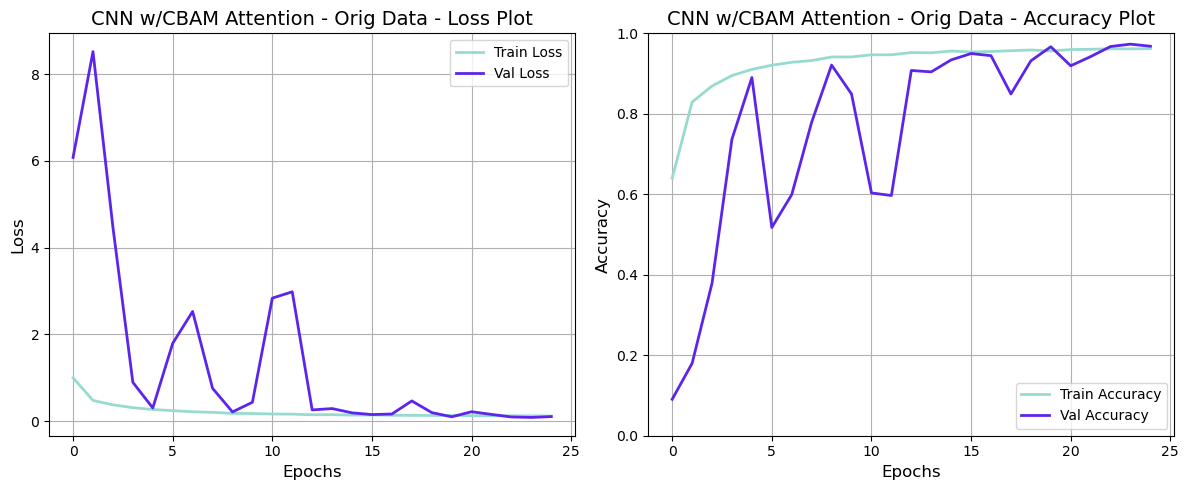

In [51]:
plot_learing_curves(history_deep_cnn_cbam, model_name='CNN w/CBAM Attention - Orig Data')

In [52]:
deep_cnn_cbam_model_performance = evaluate_model_performance(deep_cnn_cbam, test_images, test_labels)

107/107 [==============================] - 3s 24ms/step
Detailed Classification Report:
              precision    recall  f1-score   support

      class0       0.96      0.98      0.97       244
      class1       1.00      1.00      1.00       624
      class2       0.99      0.97      0.98       311
      class3       0.95      0.90      0.92       579
      class4       0.97      1.00      0.98       243
      class5       0.92      0.95      0.94       284
      class6       0.96      0.98      0.97       666
      class7       1.00      1.00      1.00       470

    accuracy                           0.97      3421
   macro avg       0.97      0.97      0.97      3421
weighted avg       0.97      0.97      0.97      3421

Test Accuracy: 96.87%
Weighted F1 Score: 0.9686
Weighted Recall: 0.9687
Weighted Precision: 0.9687


In [53]:
results_df = collect_model_results(results_df, deep_cnn_cbam_model_performance[0], deep_cnn_cbam_total_time, deep_cnn_cbam_cpu_usage, memory_res='0.47', model_name='CNN w/CBAM Attention - Orig Data')
results_df

,Model_Name,Test Accuracy (%),Weighted F1 Score,Weighted Recall,Weighted Precision,Training Time (sec),CPU Usage (%),Memory Usage (MB)
0,Baseline CNN - Original Data,90.35,0.9034,0.9035,0.9040,131,12.1,2.02
1,Baseline CNN - Augm Data,92.81,0.9287,0.9281,0.9312,194,10.9,2.02
2,CNN w/BatchNorm - Original Data,94.88,0.9488,0.9488,0.9490,126,7.6,2.02
3,CNN w/BatchNorm - Augm Data,95.53,0.9551,0.9553,0.9551,250,10.5,2.02
4,CNN model w/Skip Connections - Original Data,94.59,0.9451,0.9459,0.9496,1234,10.4,2.7
5,CNN model w/Skip Connections - Augm Data,95.76,0.9576,0.9576,0.9594,1955,17.0,2.7
6,CNN w/CBAM Attention - Orig Data,96.87,0.9686,0.9687,0.9687,810,11.0,0.47


In [54]:
# AUGMENTED DATASET
# Create the model
deep_cnn_cbam_augm = create_deep_cnn_cbam(input_shape=IMG_SHAPE, n_classes= NUM_CLASSES)
# Compile the model
deep_cnn_cbam_augm.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_time_start = time.time()
# Train the model
history_deep_cnn_cbam_augm = deep_cnn_cbam_augm.fit(
    train_images_augm, train_labels_augm,
    validation_data=(val_images_prepared, val_labels_prepared),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping_10, reduce_lr],
    shuffle=True
)

deep_cnn_cbam_augm_total_time = time.time() - total_time_start
deep_cnn_cbam_augm_cpu_usage = psutil.cpu_percent(interval=1)

print("---Model Training is done---")
print(f'Time spent on training the CNN model with skip connections: {int(deep_cnn_cbam_augm_total_time)} seconds, \n CPU Usage: {deep_cnn_cbam_augm_cpu_usage}%')

Epoch 1/25
292/292 [==============================] - 50s 164ms/step - loss: 0.9361 - accuracy: 0.6650 - val_loss: 7.5732 - val_accuracy: 0.0923 - lr: 5.0000e-04
Epoch 2/25
292/292 [==============================] - 47s 163ms/step - loss: 0.3582 - accuracy: 0.8786 - val_loss: 4.5390 - val_accuracy: 0.2926 - lr: 5.0000e-04
Epoch 3/25
292/292 [==============================] - 47s 162ms/step - loss: 0.2722 - accuracy: 0.9070 - val_loss: 3.4158 - val_accuracy: 0.4761 - lr: 5.0000e-04
Epoch 4/25
292/292 [==============================] - 48s 165ms/step - loss: 0.2288 - accuracy: 0.9244 - val_loss: 1.8921 - val_accuracy: 0.5812 - lr: 5.0000e-04
Epoch 5/25
292/292 [==============================] - 49s 166ms/step - loss: 0.2005 - accuracy: 0.9333 - val_loss: 1.5497 - val_accuracy: 0.6192 - lr: 5.0000e-04
Epoch 6/25
292/292 [==============================] - 49s 168ms/step - loss: 0.1911 - accuracy: 0.9366 - val_loss: 0.5505 - val_accuracy: 0.8113 - lr: 5.0000e-04
Epoch 7/25
292/292 [========

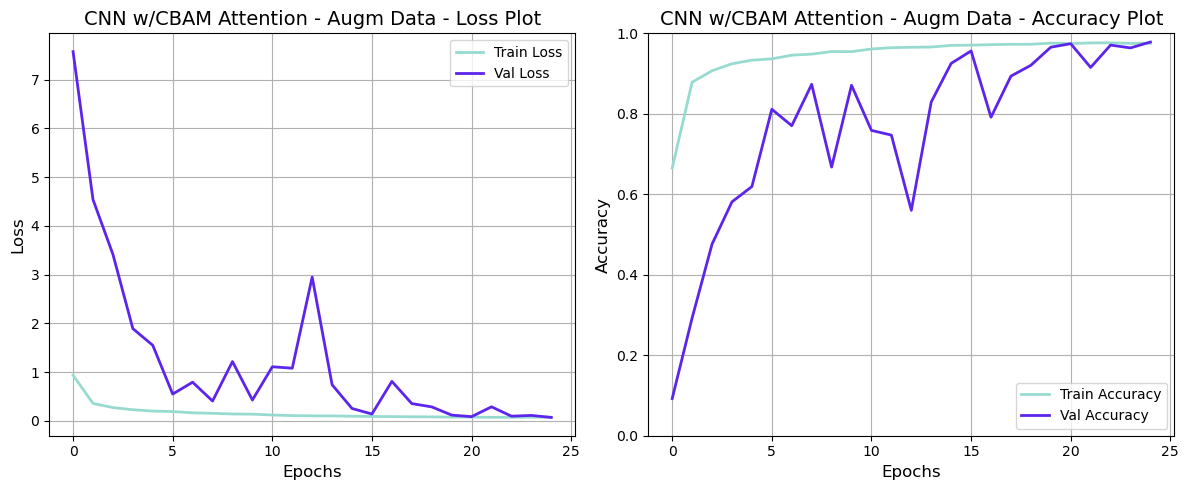

In [55]:
plot_learing_curves(history_deep_cnn_cbam_augm, model_name='CNN w/CBAM Attention - Augm Data')

In [56]:
deep_cnn_cbam_augm_performance = evaluate_model_performance(deep_cnn_cbam_augm, test_images_prepared, test_labels_prepared)

107/107 [==============================] - 3s 27ms/step
Detailed Classification Report:
              precision    recall  f1-score   support

      class0       0.98      0.99      0.99       244
      class1       1.00      1.00      1.00       624
      class2       1.00      0.97      0.99       311
      class3       0.95      0.94      0.95       579
      class4       0.98      1.00      0.99       243
      class5       0.95      0.99      0.97       284
      class6       0.97      0.96      0.97       666
      class7       1.00      1.00      1.00       470

    accuracy                           0.98      3421
   macro avg       0.98      0.98      0.98      3421
weighted avg       0.98      0.98      0.98      3421

Test Accuracy: 97.84%
Weighted F1 Score: 0.9783
Weighted Recall: 0.9784
Weighted Precision: 0.9784


In [57]:
results_df = collect_model_results(results_df, deep_cnn_cbam_augm_performance[0], deep_cnn_cbam_augm_total_time, deep_cnn_cbam_augm_cpu_usage, memory_res='0.47', model_name='CNN w/CBAM Attention - Augm Data')
results_df

,Model_Name,Test Accuracy (%),Weighted F1 Score,Weighted Recall,Weighted Precision,Training Time (sec),CPU Usage (%),Memory Usage (MB)
0,Baseline CNN - Original Data,90.35,0.9034,0.9035,0.9040,131,12.1,2.02
1,Baseline CNN - Augm Data,92.81,0.9287,0.9281,0.9312,194,10.9,2.02
2,CNN w/BatchNorm - Original Data,94.88,0.9488,0.9488,0.9490,126,7.6,2.02
3,CNN w/BatchNorm - Augm Data,95.53,0.9551,0.9553,0.9551,250,10.5,2.02
4,CNN model w/Skip Connections - Original Data,94.59,0.9451,0.9459,0.9496,1234,10.4,2.7
5,CNN model w/Skip Connections - Augm Data,95.76,0.9576,0.9576,0.9594,1955,17.0,2.7
6,CNN w/CBAM Attention - Orig Data,96.87,0.9686,0.9687,0.9687,810,11.0,0.47
7,CNN w/CBAM Attention - Augm Data,97.84,0.9783,0.9784,0.9784,1269,28.1,0.47


#### 5.2.4.2 SE Attention

**Architecture:**

- **Input:** Image of shape `input_shape`.

- **Conv Block:**
  - `Conv2D`: 32 filters, 3×3 kernel, stride 1, padding = "same"
  - `BatchNormalization`
  - `ReLU`: Activation Layer
- **SE Block**
- `MaxPool`: Pool size 2×2
- `Dropout`: Dropout rate 25%

- **Conv Block:**
  - `Conv2D`: 64 filters, 3×3 kernel, stride 1, padding = "same"
  - `BatchNormalization`
  - `ReLU`: Activation Layer
- **SE Block**
- `MaxPool`: Pool size 2×2
- `Dropout`: Dropout rate 25%

- **Conv Block:**
  - `Conv2D`: 128 filters, 3×3 kernel, stride 1, padding = "same"
  - `BatchNormalization`
  - `ReLU`: Activation Layer
- **SE Block**
- `GlobalAveragePooling`

- **Fully Connected Layers:**
  - `Dense`: Two `Dense` Layers with 128 and 64 units respectively, each followed by `Dropout` (dropout rate 40% and 20% respectively)
  - `Dense`: Final softmax layer with `n_classes` outputs for multi-class classification

In [58]:
def create_deep_cnn_se(input_shape, n_classes):
    inputs = Input(shape=input_shape)

    X = layers.Conv2D(32, kernel_size=3, padding='same', use_bias=False)(inputs)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = se_block(X, reduction=8)
    X = layers.MaxPooling2D(pool_size=2)(X)
    X = layers.Dropout(0.25)(X)

    X = layers.Conv2D(64, kernel_size=3, padding='same', use_bias=False)(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = se_block(X, reduction=8)
    X = layers.MaxPooling2D((2, 2))(X)
    X = layers.Dropout(0.25)(X)

    X = layers.Conv2D(128, (3, 3), padding='same', use_bias=False)(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = se_block(X, reduction=8)

    X = layers.GlobalAveragePooling2D()(X)

    X = layers.Dense(128, activation = 'relu')(X)
    X = layers.Dropout(0.4)(X)

    X = layers.Dense(64, activation = 'relu')(X)
    X = layers.Dropout(0.2)(X)

    # Output layer
    X = layers.Dense(n_classes, activation='softmax')(X)

    # Create model
    model = Model(inputs=inputs, outputs=X)

    return model

In [59]:
deep_cnn_se = create_deep_cnn_se(input_shape=IMG_SHAPE, n_classes = NUM_CLASSES)
deep_cnn_se.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_50 (Conv2D)          (None, 64, 64, 32)           864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_40 (Ba  (None, 64, 64, 32)           128       ['conv2d_50[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_46 (Activation)  (None, 64, 64, 32)           0         ['batch_normalization_40

In [60]:
#ORIGINAL DATASET
# Compile the model
deep_cnn_se.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_time_start = time.time()
# Train the model
history_deep_cnn_se = deep_cnn_se.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping_10, reduce_lr],
    shuffle=True
)

deep_cnn_se_total_time = time.time() - total_time_start
deep_cnn_se_cpu_usage = psutil.cpu_percent(interval=1)

print("---Model Training is done---")
print(f'Time spent on training the CNN w/SE - Original Data: {int(deep_cnn_se_total_time)} seconds, \n CPU Usage: {deep_cnn_se_cpu_usage}%')

Epoch 1/25
187/187 [==============================] - 23s 120ms/step - loss: 1.1366 - accuracy: 0.5958 - val_loss: 10.6453 - val_accuracy: 0.1373 - lr: 5.0000e-04
Epoch 2/25
187/187 [==============================] - 23s 121ms/step - loss: 0.4936 - accuracy: 0.8231 - val_loss: 12.1571 - val_accuracy: 0.1379 - lr: 5.0000e-04
Epoch 3/25
187/187 [==============================] - 24s 126ms/step - loss: 0.3393 - accuracy: 0.8864 - val_loss: 7.2173 - val_accuracy: 0.1869 - lr: 5.0000e-04
Epoch 4/25
187/187 [==============================] - 23s 121ms/step - loss: 0.2862 - accuracy: 0.9030 - val_loss: 3.7758 - val_accuracy: 0.3896 - lr: 5.0000e-04
Epoch 5/25
187/187 [==============================] - 23s 121ms/step - loss: 0.2395 - accuracy: 0.9198 - val_loss: 2.3449 - val_accuracy: 0.5625 - lr: 5.0000e-04
Epoch 6/25
187/187 [==============================] - 23s 121ms/step - loss: 0.2292 - accuracy: 0.9240 - val_loss: 3.2363 - val_accuracy: 0.4568 - lr: 5.0000e-04
Epoch 7/25
187/187 [======

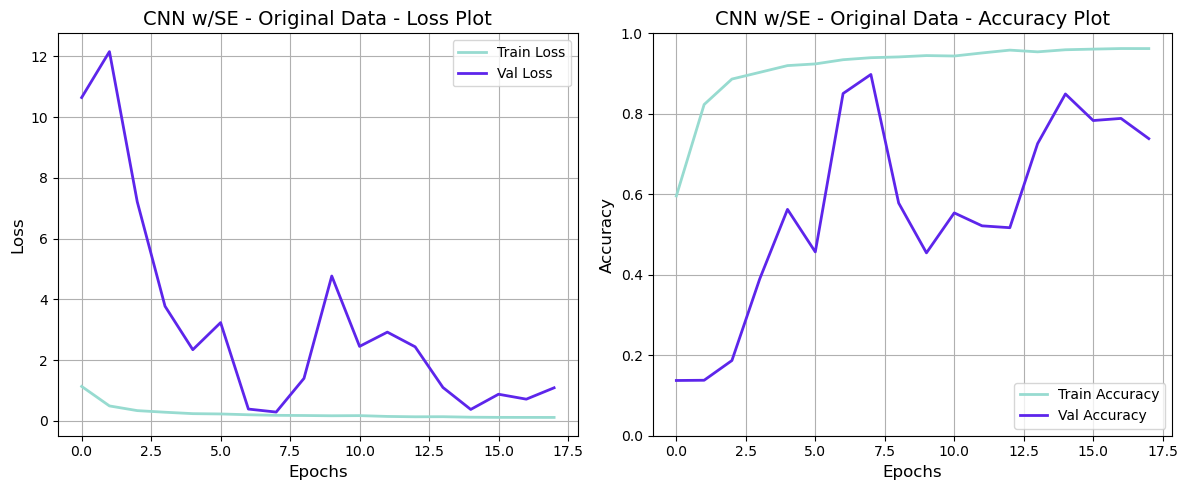

In [61]:
plot_learing_curves(history_deep_cnn_se, model_name='CNN w/SE - Original Data')

In [62]:
deep_cnn_se_performance = evaluate_model_performance(deep_cnn_se, test_images, test_labels)

107/107 [==============================] - 2s 16ms/step
Detailed Classification Report:
              precision    recall  f1-score   support

      class0       0.99      0.89      0.94       244
      class1       0.98      0.99      0.98       624
      class2       0.97      0.84      0.90       311
      class3       0.90      0.81      0.85       579
      class4       0.59      1.00      0.74       243
      class5       0.80      0.71      0.75       284
      class6       0.95      0.95      0.95       666
      class7       1.00      0.98      0.99       470

    accuracy                           0.90      3421
   macro avg       0.90      0.89      0.89      3421
weighted avg       0.92      0.90      0.91      3421

Test Accuracy: 90.47%
Weighted F1 Score: 0.9078
Weighted Recall: 0.9047
Weighted Precision: 0.9211


In [63]:
results_df = collect_model_results(results_df, deep_cnn_se_performance[0], deep_cnn_se_total_time, deep_cnn_se_cpu_usage, memory_res='0.48', model_name='CNN w/SE Attention - Orig Data')
results_df

,Model_Name,Test Accuracy (%),Weighted F1 Score,Weighted Recall,Weighted Precision,Training Time (sec),CPU Usage (%),Memory Usage (MB)
0,Baseline CNN - Original Data,90.35,0.9034,0.9035,0.9040,131,12.1,2.02
1,Baseline CNN - Augm Data,92.81,0.9287,0.9281,0.9312,194,10.9,2.02
2,CNN w/BatchNorm - Original Data,94.88,0.9488,0.9488,0.9490,126,7.6,2.02
3,CNN w/BatchNorm - Augm Data,95.53,0.9551,0.9553,0.9551,250,10.5,2.02
4,CNN model w/Skip Connections - Original Data,94.59,0.9451,0.9459,0.9496,1234,10.4,2.7
5,CNN model w/Skip Connections - Augm Data,95.76,0.9576,0.9576,0.9594,1955,17.0,2.7
6,CNN w/CBAM Attention - Orig Data,96.87,0.9686,0.9687,0.9687,810,11.0,0.47
7,CNN w/CBAM Attention - Augm Data,97.84,0.9783,0.9784,0.9784,1269,28.1,0.47
8,CNN w/SE Attention - Orig Data,90.47,0.9078,0.9047,0.9211,409,17.9,0.48


In [64]:
deep_cnn_se_augm = create_deep_cnn_se(input_shape=IMG_SHAPE, n_classes = NUM_CLASSES)

deep_cnn_se_augm.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_time_start = time.time()

history_deep_cnn_se_augm = deep_cnn_se_augm.fit(
    train_images_augm, train_labels_augm,
    validation_data=(val_images_prepared, val_labels_prepared),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping_10, reduce_lr],
    shuffle=True
)

deep_cnn_se_augm_total_time = time.time() - total_time_start
deep_cnn_se_augm_cpu_usage = psutil.cpu_percent(interval=1)

print("---Model Training is done---")
print(f'Time spent on training the CNN w/SE - Augm Data: {int(deep_cnn_se_augm_total_time)} seconds, \n CPU Usage: {deep_cnn_se_augm_cpu_usage}%')

Epoch 1/25
292/292 [==============================] - 35s 117ms/step - loss: 0.9438 - accuracy: 0.6656 - val_loss: 10.8209 - val_accuracy: 0.1373 - lr: 5.0000e-04
Epoch 2/25
292/292 [==============================] - 34s 118ms/step - loss: 0.3951 - accuracy: 0.8592 - val_loss: 3.5515 - val_accuracy: 0.3470 - lr: 5.0000e-04
Epoch 3/25
292/292 [==============================] - 34s 118ms/step - loss: 0.2884 - accuracy: 0.9021 - val_loss: 0.7302 - val_accuracy: 0.7745 - lr: 5.0000e-04
Epoch 4/25
292/292 [==============================] - 34s 118ms/step - loss: 0.2322 - accuracy: 0.9192 - val_loss: 1.1848 - val_accuracy: 0.7407 - lr: 5.0000e-04
Epoch 5/25
292/292 [==============================] - 34s 118ms/step - loss: 0.2074 - accuracy: 0.9298 - val_loss: 1.6986 - val_accuracy: 0.6893 - lr: 5.0000e-04
Epoch 6/25
292/292 [==============================] - 34s 117ms/step - loss: 0.1946 - accuracy: 0.9359 - val_loss: 0.8520 - val_accuracy: 0.7547 - lr: 5.0000e-04
Epoch 7/25
292/292 [=======

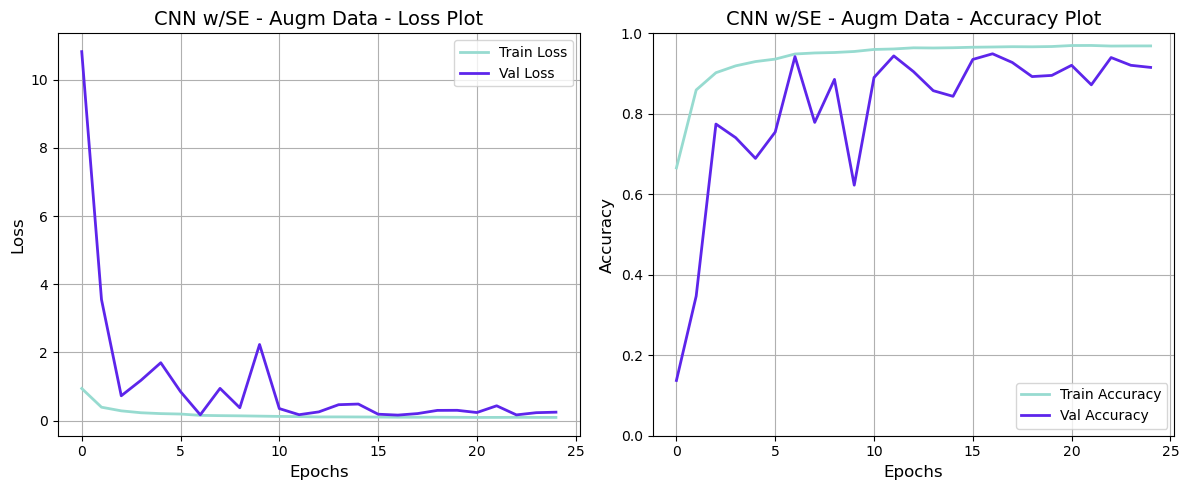

In [65]:
plot_learing_curves(history_deep_cnn_se_augm, model_name='CNN w/SE - Augm Data')

In [66]:
deep_cnn_se_augm_performance = evaluate_model_performance(deep_cnn_se_augm, test_images_prepared, test_labels_prepared)

107/107 [==============================] - 2s 20ms/step
Detailed Classification Report:
              precision    recall  f1-score   support

      class0       1.00      0.70      0.82       244
      class1       0.98      1.00      0.99       624
      class2       0.99      0.95      0.97       311
      class3       0.87      0.67      0.76       579
      class4       0.97      0.94      0.96       243
      class5       0.60      1.00      0.75       284
      class6       0.94      0.98      0.96       666
      class7       0.99      1.00      1.00       470

    accuracy                           0.91      3421
   macro avg       0.92      0.90      0.90      3421
weighted avg       0.93      0.91      0.91      3421

Test Accuracy: 90.97%
Weighted F1 Score: 0.9099
Weighted Recall: 0.9097
Weighted Precision: 0.9267


In [67]:
results_df = collect_model_results(results_df, deep_cnn_se_augm_performance[0], deep_cnn_se_augm_total_time, deep_cnn_se_augm_cpu_usage, memory_res='0.48', model_name='CNN w/SE Attention - Augm Data')
results_df

,Model_Name,Test Accuracy (%),Weighted F1 Score,Weighted Recall,Weighted Precision,Training Time (sec),CPU Usage (%),Memory Usage (MB)
0,Baseline CNN - Original Data,90.35,0.9034,0.9035,0.9040,131,12.1,2.02
1,Baseline CNN - Augm Data,92.81,0.9287,0.9281,0.9312,194,10.9,2.02
2,CNN w/BatchNorm - Original Data,94.88,0.9488,0.9488,0.9490,126,7.6,2.02
3,CNN w/BatchNorm - Augm Data,95.53,0.9551,0.9553,0.9551,250,10.5,2.02
4,CNN model w/Skip Connections - Original Data,94.59,0.9451,0.9459,0.9496,1234,10.4,2.7
5,CNN model w/Skip Connections - Augm Data,95.76,0.9576,0.9576,0.9594,1955,17.0,2.7
6,CNN w/CBAM Attention - Orig Data,96.87,0.9686,0.9687,0.9687,810,11.0,0.47
7,CNN w/CBAM Attention - Augm Data,97.84,0.9783,0.9784,0.9784,1269,28.1,0.47
8,CNN w/SE Attention - Orig Data,90.47,0.9078,0.9047,0.9211,409,17.9,0.48
9,CNN w/SE Attention - Augm Data,90.97,0.9099,0.9097,0.9267,861,26.9,0.48


### 5.2.5 Inception-Inspired CNN Model

This model incorporates custom **Inception-like blocks** to enhance representational power by allowing the network to capture features at multiple scales and depths.

**Inception Block:**

| Branch | Layers                                                                 | Output Channels |
|--------|------------------------------------------------------------------------|-----------------|
| **1**  | - `AveragePooling2D` (pool_size = (3×3), strides = (1×1), padding='same')<br> - `Conv2D` 1×1 (96 filters, ReLU) | 96              |
| **2**  | - `Conv2D_bn` 1×1 (96 filters, ReLU)                                      | 96              |
| **3**  | - `Conv2D_bn` 1×1 (64 filters, ReLU)<br> - `Conv2D_bn` 3×3 (96 filters, ReLU) | 96              |
| **4**  | - `Conv2D_bn` 1×1 (64 filters, ReLU)<br> - `Conv2D_bn` 3×3 (96 filters, ReLU)<br> - `Conv2D_bn` 3×3 (96 filters, ReLU) | 96              |

- **Each Convolution Layer** is followed by **Batch Normalization** and **ReLU activation** (applied via the `conv2d_bn` utility function).
- All four branches output tensors with 96 channels each.
- The final output is the **Concatenation** of all branches along the channel axis:
  - **Total Output Channels:** 96 × 4 = **384**
  - **Output Shape:** Same height and width as input, but with 384 channels.

---

**Model Architecture:**

- **Input:** Image of shape `input_shape`.

- **Initial Convolution + Pooling:**
   - `Conv2D`: 32 filters, 3×3 kernel, ReLU activation
   - `MaxPooling2D`: 2×2 pooling, padding = 'same'

- **Inception Block #1:**
   - Followed by MaxPooling and Dropout (25%)
- **Inception Block #2:**
   - Followed by MaxPooling and Dropout (25%)

- **Fully Connected Layers:**
   - `GlobalAveragePooling2D`: Reduces spatial dimensions
   - `Dense`: 64 units, ReLU activation
   - `Dropout`: 50% to prevent overfitting
   - `Dense`: `n_classes` units, `softmax` activation


In [68]:
def conv2d_bn(X_input, filters, kernel_size, strides, activation):
    """
    Implementation of a conv block as defined above

    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- integer, defining the number of filters in the CONV layer
    kernel_size -- (f1, f2) tuple of integers, specifying the shape of the CONV kernel
    s -- integer, specifying the stride to be used
    padding -- padding approach to be used
    name -- name for the layers

    Returns:
    X -- output of the conv2d_bn block, tensor of shape (n_H, n_W, n_C)
    """
    X = layers.Conv2D(filters = filters, kernel_size = kernel_size, strides = strides,
               padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = layers.BatchNormalization()(X)
    if activation is not None:
        X = layers.Activation(activation)(X)
    return X

def inception_block(X_input):
    # Branch 1
    branch1 = layers.AveragePooling2D((3,3), strides=(1,1), padding='same')(X_input)
    branch1 = conv2d_bn(branch1, 96, (1,1), (1,1), activation='relu')

    # Branch 2
    branch2 = conv2d_bn(X_input, 96, (1,1), (1,1), activation='relu')

    # Branch 3
    branch3 = conv2d_bn(X_input, 64, (1,1), (1,1), activation='relu')
    branch3 = conv2d_bn(branch3, 96, (3,3), (1,1), activation='relu')

    # Branch 4
    branch4 = conv2d_bn(X_input, 64, (1,1), (1,1), activation='relu')
    branch4 = conv2d_bn(branch4, 96, (3,3), (1,1), activation='relu')
    branch4 = conv2d_bn(branch4, 96, (3,3), (1,1), activation='relu')

    # Concatenate branch1, branch2, branch3 and branch4 along the channel axis
    X = tf.keras.layers.Concatenate(axis=3)([branch1, branch2, branch3, branch4])

    return X

def create_inception_cnn(input_shape, n_classes):
    inputs = layers.Input(shape=input_shape)
    # Initial Convolution and MaxPooling
    X = layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu')(inputs)
    X = layers.MaxPooling2D((2,2), padding='same')(X)

    # 1st Inception Block followed by MaxPool and Dropout
    X = inception_block(X)
    X = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(X)
    X = layers.Dropout(0.25)(X)

    # 2nd Inception Block followed by MaxPool and Dropout
    X = inception_block(X)
    X = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(X)
    X = layers.Dropout(0.25)(X)

    # GlobalAvgPool + Dense + Dropout
    X = layers.GlobalAveragePooling2D()(X)
    X = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(X)
    X = layers.Dropout(0.5)(X)

    # Output Layer
    outputs = layers.Dense(n_classes, activation='softmax')(X)
    
    model = Model(inputs = inputs, outputs = outputs)

    return model


inception_cnn = create_inception_cnn(input_shape=IMG_SHAPE, n_classes=NUM_CLASSES)
inception_cnn.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_56 (Conv2D)          (None, 64, 64, 32)           896       ['input_7[0][0]']             
                                                                                                  
 max_pooling2d_18 (MaxPooli  (None, 32, 32, 32)           0         ['conv2d_56[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_61 (Conv2D)          (None, 32, 32, 64)           2112      ['max_pooling2d_18[0][0]

In [69]:
# ORIGINAL DATASET
# Compile the model
inception_cnn.compile(
    optimizer=adam_fix,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_time_start = time.time()
# Train the model on the original dataset
history_inception_cnn = inception_cnn.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping, reduce_lr],
    shuffle=True
)

inception_cnn_total_time = time.time() - total_time_start
inception_cnn_cpu_usage = psutil.cpu_percent(interval=1)

print("---Model Training is done---")
print(f'Time spent on training the Inception CNN - Original Data: {int(inception_cnn_total_time)} seconds, \n CPU Usage: {inception_cnn_cpu_usage}%')

Epoch 1/25
187/187 [==============================] - 117s 618ms/step - loss: 1.6143 - accuracy: 0.4777 - val_loss: 4.0240 - val_accuracy: 0.1373 - lr: 1.2500e-05
Epoch 2/25
187/187 [==============================] - 106s 569ms/step - loss: 0.9758 - accuracy: 0.6802 - val_loss: 4.7828 - val_accuracy: 0.1373 - lr: 1.2500e-05
Epoch 3/25
187/187 [==============================] - 106s 566ms/step - loss: 0.8325 - accuracy: 0.7325 - val_loss: 2.6418 - val_accuracy: 0.1787 - lr: 1.2500e-05
Epoch 4/25
187/187 [==============================] - 107s 573ms/step - loss: 0.7468 - accuracy: 0.7593 - val_loss: 0.8502 - val_accuracy: 0.6945 - lr: 1.2500e-05
Epoch 5/25
187/187 [==============================] - 108s 575ms/step - loss: 0.6765 - accuracy: 0.7879 - val_loss: 0.5545 - val_accuracy: 0.8394 - lr: 1.2500e-05
Epoch 6/25
187/187 [==============================] - 105s 560ms/step - loss: 0.6199 - accuracy: 0.8060 - val_loss: 0.4824 - val_accuracy: 0.8686 - lr: 1.2500e-05
Epoch 7/25
187/187 [==

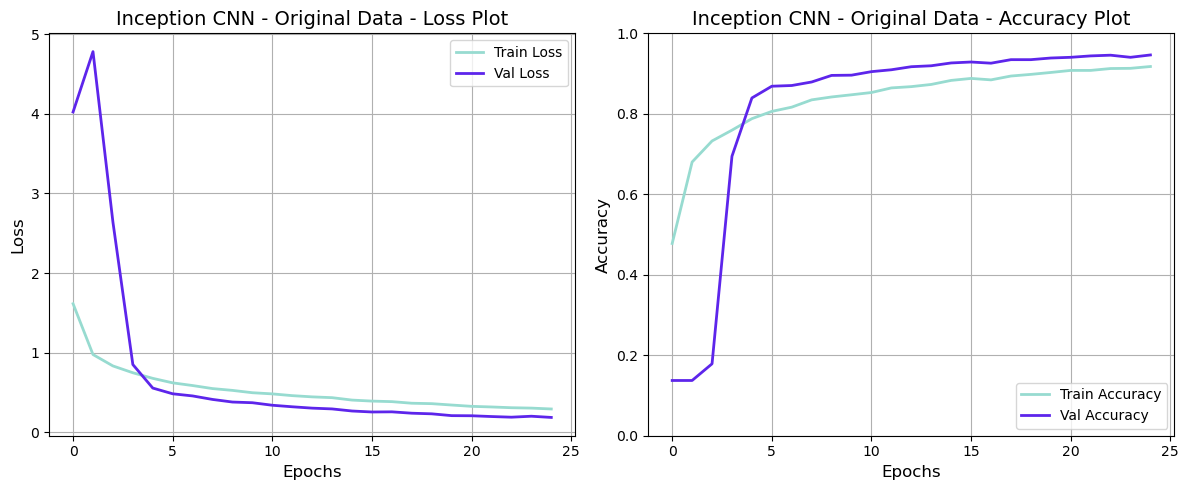

In [70]:
plot_learing_curves(history_inception_cnn, model_name='Inception CNN - Original Data')

In [71]:
inception_cnn_performance = evaluate_model_performance(inception_cnn, test_images, test_labels)

107/107 [==============================] - 8s 75ms/step
Detailed Classification Report:
              precision    recall  f1-score   support

      class0       0.96      0.91      0.93       244
      class1       0.99      0.99      0.99       624
      class2       0.98      0.91      0.94       311
      class3       0.80      0.94      0.86       579
      class4       0.99      0.89      0.94       243
      class5       0.92      0.78      0.85       284
      class6       0.96      0.95      0.96       666
      class7       0.98      1.00      0.99       470

    accuracy                           0.94      3421
   macro avg       0.95      0.92      0.93      3421
weighted avg       0.94      0.94      0.94      3421

Test Accuracy: 93.77%
Weighted F1 Score: 0.9382
Weighted Recall: 0.9377
Weighted Precision: 0.9424


In [72]:
results_df = collect_model_results(results_df, inception_cnn_performance[0], inception_cnn_total_time, inception_cnn_cpu_usage, memory_res='2.11', model_name='Inception - Original Data')
results_df

,Model_Name,Test Accuracy (%),Weighted F1 Score,Weighted Recall,Weighted Precision,Training Time (sec),CPU Usage (%),Memory Usage (MB)
0,Baseline CNN - Original Data,90.35,0.9034,0.9035,0.9040,131,12.1,2.02
1,Baseline CNN - Augm Data,92.81,0.9287,0.9281,0.9312,194,10.9,2.02
2,CNN w/BatchNorm - Original Data,94.88,0.9488,0.9488,0.9490,126,7.6,2.02
3,CNN w/BatchNorm - Augm Data,95.53,0.9551,0.9553,0.9551,250,10.5,2.02
4,CNN model w/Skip Connections - Original Data,94.59,0.9451,0.9459,0.9496,1234,10.4,2.7
5,CNN model w/Skip Connections - Augm Data,95.76,0.9576,0.9576,0.9594,1955,17.0,2.7
6,CNN w/CBAM Attention - Orig Data,96.87,0.9686,0.9687,0.9687,810,11.0,0.47
7,CNN w/CBAM Attention - Augm Data,97.84,0.9783,0.9784,0.9784,1269,28.1,0.47
8,CNN w/SE Attention - Orig Data,90.47,0.9078,0.9047,0.9211,409,17.9,0.48
9,CNN w/SE Attention - Augm Data,90.97,0.9099,0.9097,0.9267,861,26.9,0.48


In [73]:
# AUGMENTED DATASET
# Create the model
inception_cnn_augm = create_inception_cnn(input_shape=IMG_SHAPE, n_classes=NUM_CLASSES)
# Compile the model
inception_cnn_augm.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_time_start = time.time()
# Train the model on the augmented dataset
history_inception_cnn_augm = inception_cnn_augm.fit(
    train_images_augm, train_labels_augm,
    validation_data=(val_images_prepared, val_labels_prepared),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping, reduce_lr],
    shuffle=True
)

inception_cnn_augm_total_time = time.time() - total_time_start
inception_cnn_augm_cpu_usage = psutil.cpu_percent(interval=1)

print("---Model Training is done---")
print(f'Time spent on training the Inception CNN - Augm Data: {int(inception_cnn_augm_total_time)} seconds, \n CPU Usage: {inception_cnn_augm_cpu_usage}%')

Epoch 1/25
292/292 [==============================] - 161s 548ms/step - loss: 1.0419 - accuracy: 0.6502 - val_loss: 5.4653 - val_accuracy: 0.1945 - lr: 1.0000e-04
Epoch 2/25
292/292 [==============================] - 159s 544ms/step - loss: 0.4820 - accuracy: 0.8567 - val_loss: 1.0194 - val_accuracy: 0.7103 - lr: 1.0000e-04
Epoch 3/25
292/292 [==============================] - 154s 526ms/step - loss: 0.3464 - accuracy: 0.8980 - val_loss: 0.4741 - val_accuracy: 0.8061 - lr: 1.0000e-04
Epoch 4/25
292/292 [==============================] - 142s 485ms/step - loss: 0.2699 - accuracy: 0.9219 - val_loss: 0.1317 - val_accuracy: 0.9626 - lr: 1.0000e-04
Epoch 5/25
292/292 [==============================] - 151s 518ms/step - loss: 0.2339 - accuracy: 0.9311 - val_loss: 0.3482 - val_accuracy: 0.8756 - lr: 1.0000e-04
Epoch 6/25
292/292 [==============================] - 163s 557ms/step - loss: 0.2007 - accuracy: 0.9416 - val_loss: 0.1471 - val_accuracy: 0.9544 - lr: 1.0000e-04
Epoch 7/25
292/292 [==

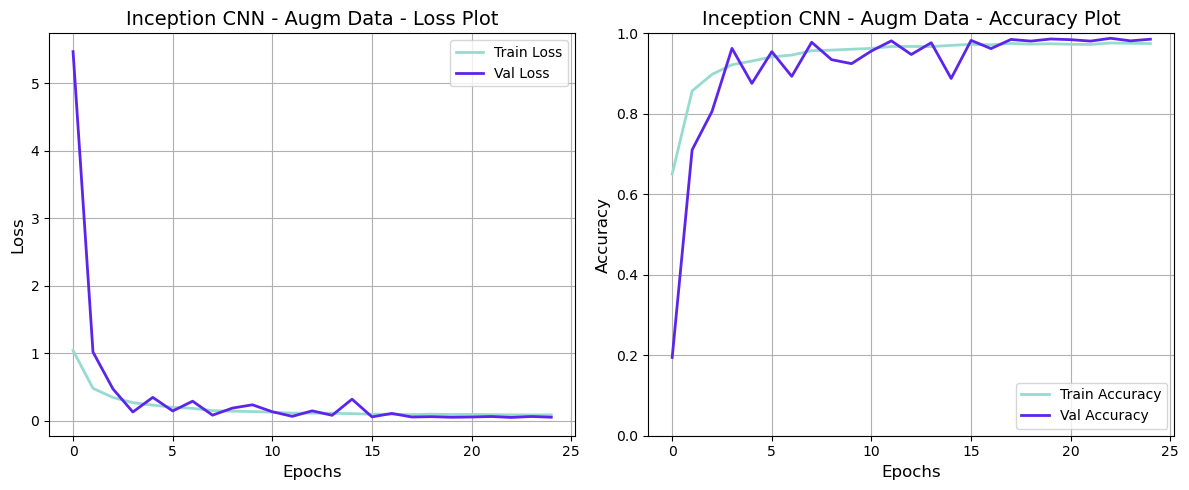

In [74]:
plot_learing_curves(history_inception_cnn_augm, model_name='Inception CNN - Augm Data')

In [75]:
inception_cnn_augm_performance = evaluate_model_performance(inception_cnn_augm, test_images_prepared, test_labels_prepared)

107/107 [==============================] - 8s 73ms/step
Detailed Classification Report:
              precision    recall  f1-score   support

      class0       0.99      0.98      0.99       244
      class1       1.00      1.00      1.00       624
      class2       0.99      0.99      0.99       311
      class3       0.96      0.96      0.96       579
      class4       0.98      0.99      0.99       243
      class5       0.98      0.99      0.98       284
      class6       0.97      0.97      0.97       666
      class7       1.00      1.00      1.00       470

    accuracy                           0.98      3421
   macro avg       0.98      0.98      0.98      3421
weighted avg       0.98      0.98      0.98      3421

Test Accuracy: 98.25%
Weighted F1 Score: 0.9825
Weighted Recall: 0.9825
Weighted Precision: 0.9825


In [76]:
results_df = collect_model_results(results_df, inception_cnn_augm_performance[0], inception_cnn_augm_total_time, inception_cnn_augm_cpu_usage, memory_res='2.11', model_name='Inception - Augm Data')
results_df

,Model_Name,Test Accuracy (%),Weighted F1 Score,Weighted Recall,Weighted Precision,Training Time (sec),CPU Usage (%),Memory Usage (MB)
0,Baseline CNN - Original Data,90.35,0.9034,0.9035,0.9040,131,12.1,2.02
1,Baseline CNN - Augm Data,92.81,0.9287,0.9281,0.9312,194,10.9,2.02
2,CNN w/BatchNorm - Original Data,94.88,0.9488,0.9488,0.9490,126,7.6,2.02
3,CNN w/BatchNorm - Augm Data,95.53,0.9551,0.9553,0.9551,250,10.5,2.02
4,CNN model w/Skip Connections - Original Data,94.59,0.9451,0.9459,0.9496,1234,10.4,2.7
5,CNN model w/Skip Connections - Augm Data,95.76,0.9576,0.9576,0.9594,1955,17.0,2.7
6,CNN w/CBAM Attention - Orig Data,96.87,0.9686,0.9687,0.9687,810,11.0,0.47
7,CNN w/CBAM Attention - Augm Data,97.84,0.9783,0.9784,0.9784,1269,28.1,0.47
8,CNN w/SE Attention - Orig Data,90.47,0.9078,0.9047,0.9211,409,17.9,0.48
9,CNN w/SE Attention - Augm Data,90.97,0.9099,0.9097,0.9267,861,26.9,0.48


#### 5.2.6 Visual Transformer

This model implements a lightweight Vision Transformer architecture, designed to capture spatial relationships in image data using self-attention and patch-wise processing.

**Architecture Overview**

1. Patch + Positional Embedding: Input image is split into non-overlapping 4×4 patches using a Conv2D layer. Each patch is projected to a 64-dimensional embedding vector. Learnable positional embeddings are added to retain spatial order.

2. Transformer Encoder (1 Block)
    - `LayerNormalization`
    - `MultiHeadSelfAttention` with 8 heads and key dimension = 8
    - `Add`: Add the result of MultiHeadAttention layer and initial Embedding
    - `LayerNormalization`
    - `MLP`: Two Dense layers (128 and 64 units respectively) with GELU activation and dropout (20% dropout rat)


3. Classification Head
    - `LayerNormalization` + `Flatten`
    - `Dropout`: 50% dropout rate
    - `MLP`: Two Dense layers (512 and 256 units respectively) with GELU activation and dropout (30% dropout rate)
    - `Dense`: `n_classes` units, `softmax` activation

In [ ]:
patch_size=4
embed_dim=64
mlp_head_units = [2048, 1024]

def patch_and_position_embedding(input, patch_size=4, embed_dim=64):
    """
    Applies Conv2D-based patch extraction and adds learnable positional embeddings.

    """
    input_shape = input.shape[1:3]
    assert input_shape[0] % patch_size == 0 and input_shape[1] % patch_size == 0, "Image size must be divisible by patch size"
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

    # Patching via Conv2D
    x = layers.Conv2D(
        filters=embed_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding='valid')(input)

    # Flatten patches
    x = layers.Reshape((num_patches, embed_dim))(x)

    # Positional embeddings (learnable)
    positions = tf.expand_dims(tf.range(num_patches), axis=0)
    pos_embed = layers.Embedding(
        input_dim=num_patches,
        output_dim=embed_dim)(positions)

    # Add positional embeddings
    embedding = layers.Add()([x, pos_embed])
    return embedding

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation='gelu')(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def create_vit(input_shape,num_classes, transformer_layers, hidden_units, mlp_head_units, num_heads = 8):
    inputs = Input(input_shape)
    
    # patching the input image into patches
    embedding = patch_and_position_embedding(inputs, patch_size, embed_dim)
    
    # Create multiple layers of transformer block
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(embedding)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)(x1,x1)
        x2 = layers.Add()([attention_output, embedding])
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x2, hidden_units=hidden_units, dropout_rate=0.2)
        encod_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encod_patches)    
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    features = mlp(representation,hidden_units=mlp_head_units,dropout_rate=0.3)
    outputs = layers.Dense(num_classes, activation='softmax')(features)
    
    model = Model(inputs=inputs, outputs=[outputs])
    return model

In [78]:
vit = create_vit(input_shape = IMG_SHAPE, num_classes=NUM_CLASSES, transformer_layers = 1, hidden_units = [embed_dim*2, embed_dim], mlp_head_units= [512, 256])
vit.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_86 (Conv2D)          (None, 16, 16, 64)           3136      ['input_9[0][0]']             
                                                                                                  
 reshape_6 (Reshape)         (None, 256, 64)              0         ['conv2d_86[0][0]']           
                                                                                                  
 add_18 (Add)                (None, 256, 64)              0         ['reshape_6[0][0]']           
                                                                                            

In [79]:
# ORIGINAL DATASET
#Compile the model
vit.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_time_start = time.time()
# Train the model
history_vit = vit.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping, reduce_lr],
    shuffle=True
)

vit_total_time = time.time() - total_time_start
vit_cpu_usage = psutil.cpu_percent(interval=1)

print("---Model Training is done---")
print(f'Time spent on training the Visual Transformer on Augm Dataset: {int(vit_total_time)} seconds, \n CPU Usage: {vit_cpu_usage}%')

Epoch 1/25
187/187 [==============================] - 38s 200ms/step - loss: 1.6116 - accuracy: 0.4167 - val_loss: 0.7086 - val_accuracy: 0.7401 - lr: 1.0000e-04
Epoch 2/25
187/187 [==============================] - 37s 198ms/step - loss: 0.8626 - accuracy: 0.6853 - val_loss: 0.5197 - val_accuracy: 0.8248 - lr: 1.0000e-04
Epoch 3/25
187/187 [==============================] - 38s 201ms/step - loss: 0.6775 - accuracy: 0.7516 - val_loss: 0.4314 - val_accuracy: 0.8516 - lr: 1.0000e-04
Epoch 4/25
187/187 [==============================] - 37s 200ms/step - loss: 0.5879 - accuracy: 0.7909 - val_loss: 0.4080 - val_accuracy: 0.8598 - lr: 1.0000e-04
Epoch 5/25
187/187 [==============================] - 39s 206ms/step - loss: 0.4953 - accuracy: 0.8205 - val_loss: 0.3776 - val_accuracy: 0.8703 - lr: 1.0000e-04
Epoch 6/25
187/187 [==============================] - 39s 206ms/step - loss: 0.4560 - accuracy: 0.8374 - val_loss: 0.3007 - val_accuracy: 0.8919 - lr: 1.0000e-04
Epoch 7/25
187/187 [========

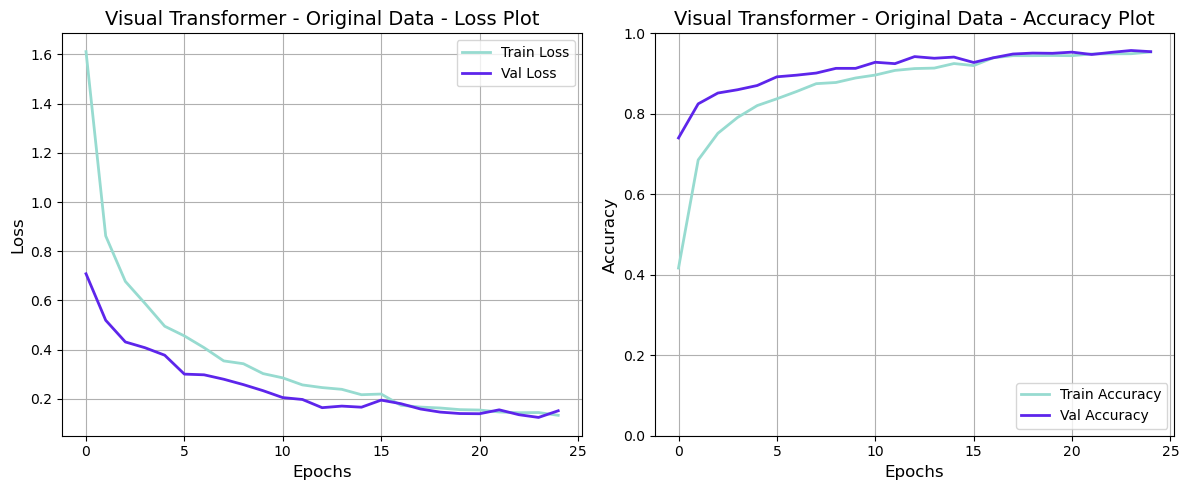

In [80]:
plot_learing_curves(history_vit, model_name='Visual Transformer - Original Data')

In [81]:
vit_performance = evaluate_model_performance(vit, test_images, test_labels)

107/107 [==============================] - 5s 49ms/step
Detailed Classification Report:
              precision    recall  f1-score   support

      class0       0.93      0.89      0.91       244
      class1       1.00      1.00      1.00       624
      class2       0.99      0.93      0.96       311
      class3       0.90      0.85      0.87       579
      class4       0.97      0.96      0.96       243
      class5       0.87      0.93      0.90       284
      class6       0.93      0.99      0.96       666
      class7       1.00      1.00      1.00       470

    accuracy                           0.95      3421
   macro avg       0.95      0.94      0.94      3421
weighted avg       0.95      0.95      0.95      3421

Test Accuracy: 94.86%
Weighted F1 Score: 0.9483
Weighted Recall: 0.9486
Weighted Precision: 0.9488


In [82]:
results_df = collect_model_results(results_df, vit_performance[0], vit_total_time, vit_cpu_usage, memory_res='0.78', model_name='ViT - Orig Data')
results_df

,Model_Name,Test Accuracy (%),Weighted F1 Score,Weighted Recall,Weighted Precision,Training Time (sec),CPU Usage (%),Memory Usage (MB)
0,Baseline CNN - Original Data,90.35,0.9034,0.9035,0.9040,131,12.1,2.02
1,Baseline CNN - Augm Data,92.81,0.9287,0.9281,0.9312,194,10.9,2.02
2,CNN w/BatchNorm - Original Data,94.88,0.9488,0.9488,0.9490,126,7.6,2.02
3,CNN w/BatchNorm - Augm Data,95.53,0.9551,0.9553,0.9551,250,10.5,2.02
4,CNN model w/Skip Connections - Original Data,94.59,0.9451,0.9459,0.9496,1234,10.4,2.7
5,CNN model w/Skip Connections - Augm Data,95.76,0.9576,0.9576,0.9594,1955,17.0,2.7
6,CNN w/CBAM Attention - Orig Data,96.87,0.9686,0.9687,0.9687,810,11.0,0.47
7,CNN w/CBAM Attention - Augm Data,97.84,0.9783,0.9784,0.9784,1269,28.1,0.47
8,CNN w/SE Attention - Orig Data,90.47,0.9078,0.9047,0.9211,409,17.9,0.48
9,CNN w/SE Attention - Augm Data,90.97,0.9099,0.9097,0.9267,861,26.9,0.48


In [83]:
# AUGMENTED DATASET
# Create the model
vit_augm = create_vit(input_shape = IMG_SHAPE, num_classes=NUM_CLASSES, transformer_layers = 1, hidden_units = [embed_dim*2, embed_dim], mlp_head_units= [512, 256])

#Compile the model
vit_augm.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_time_start = time.time()
# Train the model
history_vit_augm = vit_augm.fit(
    train_images_augm, train_labels_augm,
    validation_data=(val_images_prepared, val_labels_prepared),
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks = [early_stopping,reduce_lr],
    shuffle=True
)

vit_augm_total_time = time.time() - total_time_start
vit_augm_cpu_usage = psutil.cpu_percent(interval=1)

print("---Model Training is done---")
print(f'Time spent on training the Visual Transformer on Augm Dataset: {int(vit_augm_total_time)} seconds, \n CPU Usage: {vit_augm_cpu_usage}%')

Epoch 1/25
292/292 [==============================] - 55s 187ms/step - loss: 1.4864 - accuracy: 0.4393 - val_loss: 0.7074 - val_accuracy: 0.7699 - lr: 1.0000e-04
Epoch 2/25
292/292 [==============================] - 57s 195ms/step - loss: 0.8337 - accuracy: 0.6954 - val_loss: 0.5015 - val_accuracy: 0.8259 - lr: 1.0000e-04
Epoch 3/25
292/292 [==============================] - 55s 188ms/step - loss: 0.6606 - accuracy: 0.7652 - val_loss: 0.4350 - val_accuracy: 0.8417 - lr: 1.0000e-04
Epoch 4/25
292/292 [==============================] - 56s 192ms/step - loss: 0.5402 - accuracy: 0.8091 - val_loss: 0.3534 - val_accuracy: 0.8779 - lr: 1.0000e-04
Epoch 5/25
292/292 [==============================] - 55s 189ms/step - loss: 0.4635 - accuracy: 0.8398 - val_loss: 0.2922 - val_accuracy: 0.8919 - lr: 1.0000e-04
Epoch 6/25
292/292 [==============================] - 56s 193ms/step - loss: 0.4020 - accuracy: 0.8598 - val_loss: 0.2846 - val_accuracy: 0.9030 - lr: 1.0000e-04
Epoch 7/25
292/292 [========

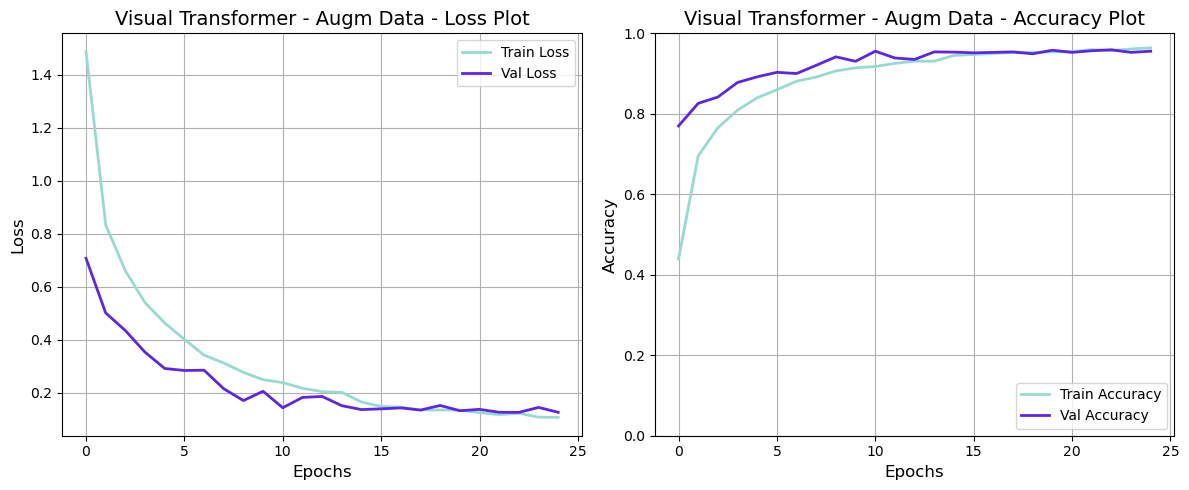

In [84]:
plot_learing_curves(history_vit_augm, model_name='Visual Transformer - Augm Data')

In [85]:
vit_augm_performance = evaluate_model_performance(vit_augm, test_images_prepared, test_labels_prepared)

107/107 [==============================] - 6s 51ms/step
Detailed Classification Report:
              precision    recall  f1-score   support

      class0       0.89      0.97      0.93       244
      class1       1.00      1.00      1.00       624
      class2       0.95      0.96      0.96       311
      class3       0.89      0.88      0.89       579
      class4       0.97      0.96      0.97       243
      class5       0.96      0.86      0.91       284
      class6       0.95      0.97      0.96       666
      class7       1.00      0.99      1.00       470

    accuracy                           0.95      3421
   macro avg       0.95      0.95      0.95      3421
weighted avg       0.95      0.95      0.95      3421

Test Accuracy: 95.32%
Weighted F1 Score: 0.9530
Weighted Recall: 0.9532
Weighted Precision: 0.9537


In [86]:
results_df = collect_model_results(results_df, vit_augm_performance[0], vit_augm_total_time, vit_augm_cpu_usage, memory_res='0.78', model_name='ViT - Augm Data')
results_df

,Model_Name,Test Accuracy (%),Weighted F1 Score,Weighted Recall,Weighted Precision,Training Time (sec),CPU Usage (%),Memory Usage (MB)
0,Baseline CNN - Original Data,90.35,0.9034,0.9035,0.9040,131,12.1,2.02
1,Baseline CNN - Augm Data,92.81,0.9287,0.9281,0.9312,194,10.9,2.02
2,CNN w/BatchNorm - Original Data,94.88,0.9488,0.9488,0.9490,126,7.6,2.02
3,CNN w/BatchNorm - Augm Data,95.53,0.9551,0.9553,0.9551,250,10.5,2.02
4,CNN model w/Skip Connections - Original Data,94.59,0.9451,0.9459,0.9496,1234,10.4,2.7
5,CNN model w/Skip Connections - Augm Data,95.76,0.9576,0.9576,0.9594,1955,17.0,2.7
6,CNN w/CBAM Attention - Orig Data,96.87,0.9686,0.9687,0.9687,810,11.0,0.47
7,CNN w/CBAM Attention - Augm Data,97.84,0.9783,0.9784,0.9784,1269,28.1,0.47
8,CNN w/SE Attention - Orig Data,90.47,0.9078,0.9047,0.9211,409,17.9,0.48
9,CNN w/SE Attention - Augm Data,90.97,0.9099,0.9097,0.9267,861,26.9,0.48


### Save the trained models

In [88]:
baseline_cnn_model.save('baseline_cnn.h5')
baseline_cnn_model_augm.save('baseline_cnn_augm.h5')
cnn_model_batch_norm.save('cnn_batch_norm.h5')
cnn_model_batch_norm_augm.save('cnn_batch_norm_augm.h5')
cnn_skip_connections.save('cnn_skip_connections.h5')
cnn_skip_connections_augm.save('cnn_skip_connections_augm.h5')
deep_cnn_cbam.save('deep_cnn_cbam.h5')
deep_cnn_cbam_augm.save('deep_cnn_cbam_augm.h5')
deep_cnn_se.save('deep_cnn_se.h5')
deep_cnn_se_augm.save('deep_cnn_se_augm.h5')
inception_cnn.save('inception_cnn.h5')
inception_cnn_augm.save('inception_cnn_augm.h5')
vit.save('vit.h5')
vit_augm.save('vit_augm.h5')

/Users/aleksandramaslova/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [89]:
histories = [
    ('Baseline CNN - Original', history_baseline_cnn_model),
    ('Baseline CNN - Augmented', history_baseline_cnn_augm_model),
    ('Baseline + BatchNorm - Original', history_cnn_model_batch_norm),
    ('Baseline + BatchNorm - Augmented', history_cnn_model_batch_norm_augm),
    ('CNN w/Skip Connections - Original', history_cnn_skip_connections),
    ('CNN w/Skip Connections - Augmented', history_cnn_skip_connections_augm),
    ('CNN w/CBAM - Original', history_deep_cnn_cbam),
    ('CNN w/CBAM - Augmented', history_deep_cnn_cbam_augm),
    ('CNN w/SE - Original', history_deep_cnn_se),
    ('CNN w/SE - Augmented', history_deep_cnn_se_augm),
    ('Inception - Original', history_inception_cnn),
    ('Inception - Augmented', history_inception_cnn_augm),
    ('ViT - Original', history_vit),
    ('ViT - Augmented', history_vit_augm),
]

In [ ]:
def plot_val_curves(histories):
    
    plt.figure(figsize=(14, 6))
    colors = plt.cm.hsv(np.linspace(0, 1, 15)) 

    # --- Validation Loss subplot ---
    plt.subplot(1, 2, 1)
    for idx, (model_name, history) in enumerate(histories):
        plt.plot(history.history['val_loss'], label=model_name, color=colors[idx], linewidth=2)
    plt.title('Validation Loss Across Models')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.grid(True)
    plt.legend()

    # --- Validation Accuracy subplot ---
    plt.subplot(1, 2, 2)
    for idx, (model_name, history) in enumerate(histories):
        plt.plot(history.history['val_accuracy'], label=model_name, color=colors[idx], linewidth=2)
    plt.title('Validation Accuracy Across Models')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

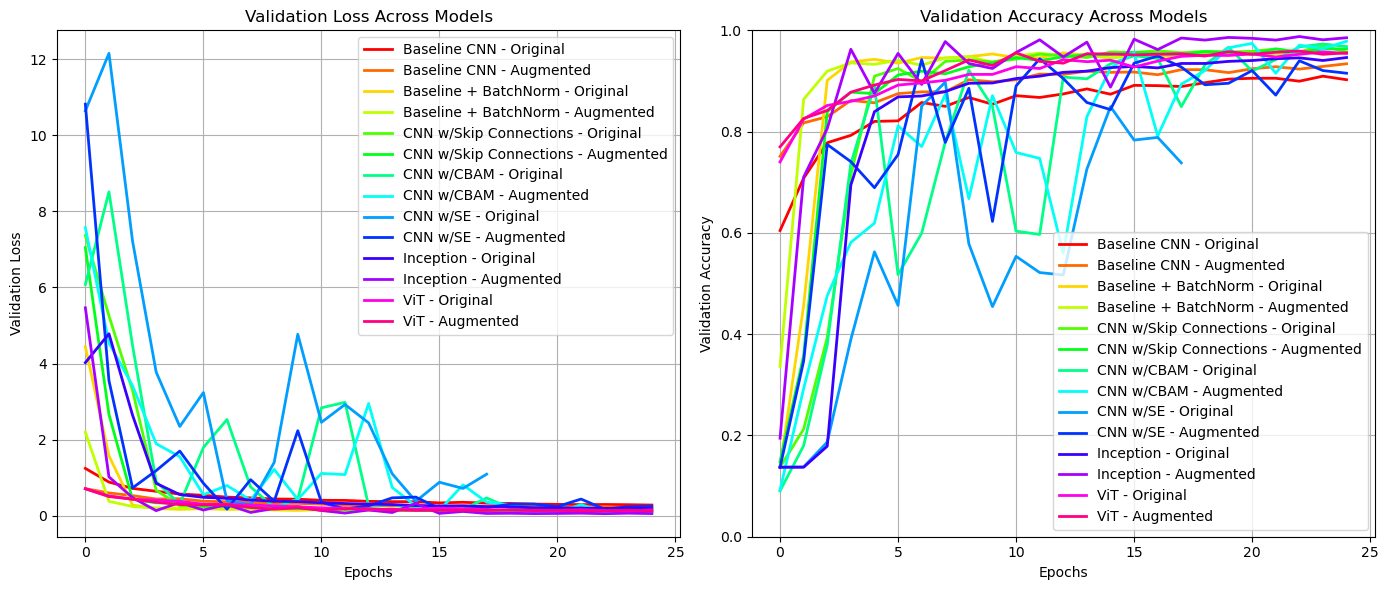

In [93]:
plot_val_curves(histories)